--- Part 1: Data Preparation for 'Age' Group Analysis ---

--- Step 1.1: Loading and Standard Cleaning ---
Standard data cleaning applied.
Cleaned DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    int8   
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    int8   
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    int8   
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        920 non-null    int8   
 14  thal      920 non-null    object 
 15  target    920 non-null    int64  
dtypes: float64(4), int64(3), 

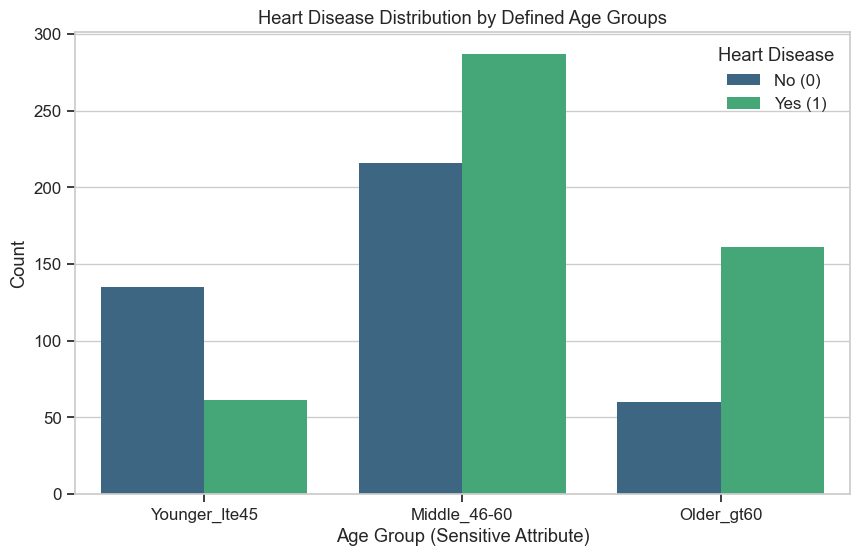


--- Step 1.3: Separating Features (X) and Target (y) ---
Shape of features X (will include 'age' and 'age_group'): (920, 14)
Shape of target y: (920,)

--- Step 1.4: Identifying Numerical and Categorical Features for Preprocessing ---
Final Numerical Features for Preprocessing pipeline: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Final Categorical Features for Preprocessing pipeline: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

--- Step 1.5: Splitting Data into Training and Test Sets ---
Training set shape: X_train_for_model-(690, 13), y_train-(690,)
Test set shape: X_test_for_model-(230, 13), y_test-(230,)
Sensitive attribute ('age_group') for X_train: (690,)
Sensitive attribute ('age_group') for X_test: (230,)

--- Step 1.6: Setting up Preprocessing Pipeline ---
Processed feature count for age analysis: 20

First 5 rows of processed training data for age analysis (X_train_processed_age_df):
     num__age  num__trestbps  num__chol  num__thalch  num__oldpeak  

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt # For initial visualization of age groups
import seaborn as sns # For initial visualization
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

# --- 1. Data Loading and Standard Cleaning ---
print("--- Part 1: Data Preparation for 'Age' Group Analysis ---")
print("\n--- Step 1.1: Loading and Standard Cleaning ---")
file_path = 'heart_disease_uci.csv'
df = pd.read_csv(file_path)

# Target variable: Rename 'num' to 'target' and binarize
if 'num' in df.columns and 'target' not in df.columns: df.rename(columns={'num': 'target'}, inplace=True)
if 'target' in df.columns: df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Sex encoding
if 'sex' in df.columns:
    df['sex'] = df['sex'].map({'Female': 0, 'Male': 1})
    if df['sex'].isnull().any(): df['sex'].fillna(df['sex'].mode()[0], inplace=True)
    df['sex'] = df['sex'].astype(np.int8)

# Boolean-like features
for col_name in ['fbs', 'exang']:
    if col_name in df.columns:
        df[col_name] = df[col_name].replace({True: 1, False: 0, 'True': 1, 'False': 0, 1.0: 1, 0.0: 0})
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
        if df[col_name].isnull().sum() > 0: df[col_name].fillna(df[col_name].mode()[0], inplace=True)
        df[col_name] = df[col_name].astype(np.int8)

# Other categorical feature imputation (mode)
for col in ['restecg', 'cp', 'slope', 'thal']:
    if col in df.columns and df[col].isnull().any(): df[col].fillna(df[col].mode()[0], inplace=True)

# Numerical feature imputation (median) & ensuring numeric type
for col in ['trestbps', 'chol', 'thalch', 'oldpeak']: # 'thalch' is correct
    if col in df.columns:
        if df[col].isnull().any(): df[col].fillna(df[col].median(), inplace=True)
        df[col] = pd.to_numeric(df[col], errors='coerce') # Ensure numeric
        if df[col].isnull().any(): df[col].fillna(df[col].median(), inplace=True) # Re-impute if coerce created NaNs

# 'ca' imputation and type conversion
if 'ca' in df.columns:
    if df['ca'].isnull().any(): df['ca'].fillna(df['ca'].mode()[0], inplace=True)
    df['ca'] = df['ca'].astype(np.int8)

print("Standard data cleaning applied.")
print(f"Cleaned DataFrame info:")
df.info()
print(f"\nMissing values after cleaning:\n{df.isnull().sum()}")

# --- 2. Age Group Creation ---
print("\n--- Step 1.2: Creating 'age_group' as the Sensitive Attribute ---")
# Define age bins and labels
# Option 1: Fixed bins (example)
age_bins = [0, 45, 60, float('inf')] # Bins: <=45, 46-60, >60
age_labels = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']

# Option 2: Quantile-based bins (e.g., 3 groups with roughly equal numbers)
# For qcut, ensure no duplicate edges, which can happen with discrete data like age
# For simplicity and interpretability, let's stick with fixed bins for now.
# If you prefer quantiles:
# try:
#     df['age_group_q'] = pd.qcut(df['age'], q=3, labels=['LowAge', 'MidAge', 'HighAge'], duplicates='drop')
# except ValueError as e:
#     print(f"Could not create quantile bins due to: {e}. Using fixed bins.")

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)

print("\nAge groups created:")
print(df['age_group'].value_counts(dropna=False).sort_index())

# Visualize the distribution of age groups and target within them
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', hue='target', palette='viridis', order=age_labels)
plt.title('Heart Disease Distribution by Defined Age Groups')
plt.xlabel('Age Group (Sensitive Attribute)')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No (0)', 'Yes (1)'])
plt.show()

SENSITIVE_ATTRIBUTE_AGE = 'age_group' # This will be our new sensitive attribute

# --- 3. Feature/Target Separation ---
print("\n--- Step 1.3: Separating Features (X) and Target (y) ---")
if 'target' not in df.columns:
    print("Error: 'target' column not found. Exiting.")
    exit()

# X will contain the original 'age' feature for modeling.
# 'age_group' will be kept alongside X (e.g., in X_train, X_test) for Fairlearn's sensitive_features argument.
# We will not drop 'age_group' from X yet, as it's needed for train_test_split alignment.
# It will be excluded from X_processed later if 'age' is already there.
X = df.drop(columns=['target', 'id', 'dataset'], errors='ignore')
y = df['target']

print(f"Shape of features X (will include 'age' and 'age_group'): {X.shape}")
print(f"Shape of target y: {y.shape}")

# --- 4. Define Feature Lists for Preprocessing ---
print("\n--- Step 1.4: Identifying Numerical and Categorical Features for Preprocessing ---")
# 'age' is numerical and will be scaled. 'age_group' is our sensitive attribute, not directly part of X_processed.
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'] # 'age_group' is NOT in here

# Ensure all listed features are in X's columns
actual_numerical_features = [f for f in numerical_features if f in X.columns]
actual_categorical_features = [f for f in categorical_features if f in X.columns]

if len(actual_numerical_features) != len(numerical_features):
    print(f"Warning: Numerical features mismatch. Using: {actual_numerical_features}")
if len(actual_categorical_features) != len(categorical_features):
    print(f"Warning: Categorical features mismatch. Using: {actual_categorical_features}")

numerical_features = actual_numerical_features
categorical_features = actual_categorical_features

print(f"Final Numerical Features for Preprocessing pipeline: {numerical_features}")
print(f"Final Categorical Features for Preprocessing pipeline: {categorical_features}")


# --- 5. Train-Test Split ---
# We split X (which includes 'age_group' at this stage) and y.
# This ensures 'age_group' is aligned with X_train and X_test for later use.
print("\n--- Step 1.5: Splitting Data into Training and Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Separate sensitive attribute for train and test sets
X_train_sensitive_age_group = X_train[SENSITIVE_ATTRIBUTE_AGE].copy()
X_test_sensitive_age_group = X_test[SENSITIVE_ATTRIBUTE_AGE].copy()

# Now, X_train and X_test for actual model input should not include 'age_group'
# if 'age' (the raw feature) is already being used.
# The preprocessor will select columns from these DataFrames.
X_train_for_model = X_train.drop(columns=[SENSITIVE_ATTRIBUTE_AGE], errors='ignore')
X_test_for_model = X_test.drop(columns=[SENSITIVE_ATTRIBUTE_AGE], errors='ignore')


print(f"Training set shape: X_train_for_model-{X_train_for_model.shape}, y_train-{y_train.shape}")
print(f"Test set shape: X_test_for_model-{X_test_for_model.shape}, y_test-{y_test.shape}")
print(f"Sensitive attribute ('{SENSITIVE_ATTRIBUTE_AGE}') for X_train: {X_train_sensitive_age_group.shape}")
print(f"Sensitive attribute ('{SENSITIVE_ATTRIBUTE_AGE}') for X_test: {X_test_sensitive_age_group.shape}")


# --- 6. Preprocessing Pipeline Setup ---
print("\n--- Step 1.6: Setting up Preprocessing Pipeline ---")
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# The preprocessor will operate on X_train_for_model and X_test_for_model
# (which do not contain 'age_group' as a feature to be transformed if 'age' is used).
preprocessor_age = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), # 'age' is in numerical_features
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_train_processed_age = preprocessor_age.fit_transform(X_train_for_model)
X_test_processed_age = preprocessor_age.transform(X_test_for_model)

try:
    feature_names_out_age = preprocessor_age.get_feature_names_out()
    print(f"Processed feature count for age analysis: {len(feature_names_out_age)}")
    # Convert processed arrays back to DataFrames (optional)
    X_train_processed_age_df = pd.DataFrame(X_train_processed_age, columns=feature_names_out_age, index=X_train_for_model.index)
    X_test_processed_age_df = pd.DataFrame(X_test_processed_age, columns=feature_names_out_age, index=X_test_for_model.index)
    print("\nFirst 5 rows of processed training data for age analysis (X_train_processed_age_df):")
    print(X_train_processed_age_df.head())
except Exception as e:
    print(f"Error getting feature names or creating processed DataFrames for age analysis: {e}")
    print(f"Shape of X_train_processed_age: {X_train_processed_age.shape}")

# For later use (e.g. helper functions), ensure y_test is a Series with correct index
y_test_series_age = pd.Series(y_test, name='target')
if not X_test_for_model.index.equals(y_test_series_age.index):
     y_test_series_age.index = X_test_for_model.index # Align index


print("\n--- Part 1: Data Preparation for 'Age' Group Analysis Finished ---")
# Key variables for next parts:
# X_train_processed_age, X_test_processed_age, y_train, y_test_series_age
# X_train_sensitive_age_group, X_test_sensitive_age_group (for Fairlearn and subgroup analysis)
# SENSITIVE_ATTRIBUTE_AGE (name of the sensitive attribute column: 'age_group')
# preprocessor_age (the fitted ColumnTransformer)

Using variables from Part 1 (Age Analysis Data Prep) for model training.

--- Part 2: Unmitigated Model Training & Overall Evaluation (Age Analysis) ---

--- Step 2.1: Defining Models ---
Logistic Regression model for age analysis defined: LogisticRegression(max_iter=1000, random_state=42)
Random Forest model for age analysis defined: RandomForestClassifier(random_state=42)

--- Step 2.2: Training Models (on Age Processed Data) ---
Logistic Regression model (age analysis) trained successfully.
Random Forest model (age analysis) trained successfully.

--- Step 2.3: Making Predictions (on Age Processed Test Data) ---
Predictions made with Logistic Regression (age analysis).
Predictions made with Random Forest (age analysis).

--- Step 2.4: Overall Model Evaluation (Age Analysis) ---

--- Overall Evaluation: Logistic Regression (Age Analysis) ---
Accuracy: 0.8522
ROC AUC: 0.9114
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.8

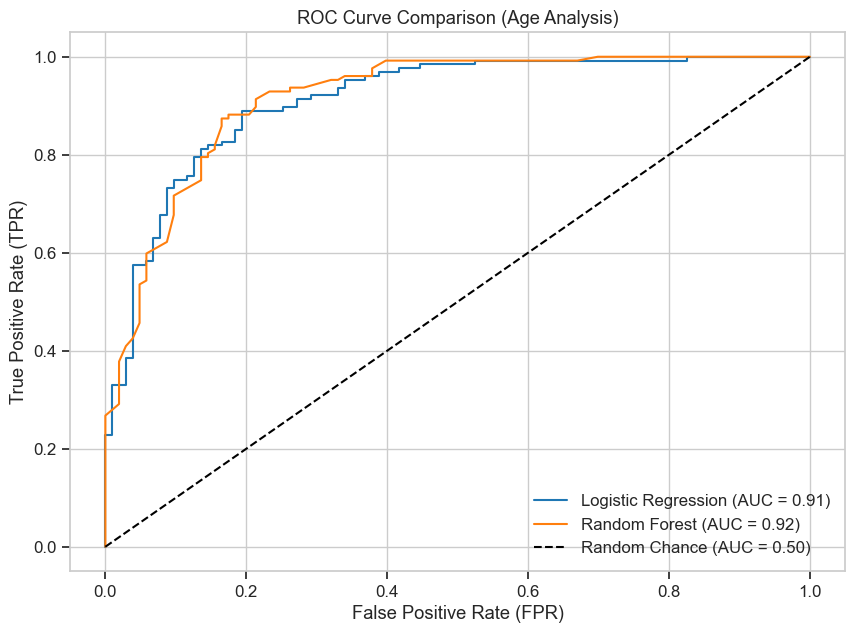


--- Part 2: Unmitigated Model Training & Overall Evaluation (Age Analysis) Finished ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For plotting styles

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid') # Consistent styling
sns.set_context("notebook", font_scale=1.1)

# --- Assume variables from Part 1 (Age Analysis Data Prep) are available: ---
# X_train_processed_age, X_test_processed_age, y_train, y_test_series_age

# For this part to be runnable if prior variables aren't in the active environment,
# we might need placeholder data. However, for model training, meaningful data is essential.
# We'll proceed assuming Part 1 (Age Analysis) has been run successfully.
if ('X_train_processed_age' not in locals() or
    'X_test_processed_age' not in locals() or
    'y_train' not in locals() or
    'y_test_series_age' not in locals()):
    print("Error: Training/test data for age analysis from Part 1 not found. Please run Part 1 first.")
    # As a fallback for demonstration if running isolated, create tiny dummy data:
    # This is NOT for actual analysis.
    print("Using minimal dummy data for demonstration purposes ONLY.")
    num_features_standin_age = 15 # Example number of features after preprocessing for age
    X_train_processed_age = np.random.rand(225, num_features_standin_age)
    X_test_processed_age = np.random.rand(75, num_features_standin_age)
    y_train = pd.Series(np.random.randint(0, 2, 225)) # Ensure y_train is Series if y_test_series_age is
    y_test_series_age = pd.Series(np.random.randint(0, 2, 75), name='target')
else:
    print("Using variables from Part 1 (Age Analysis Data Prep) for model training.")


print("\n--- Part 2: Unmitigated Model Training & Overall Evaluation (Age Analysis) ---")

# --- 1. Model Definitions ---
print("\n--- Step 2.1: Defining Models ---")
log_reg_age = LogisticRegression(random_state=42, max_iter=1000)
rand_forest_age = RandomForestClassifier(random_state=42, n_estimators=100)

print(f"Logistic Regression model for age analysis defined: {log_reg_age}")
print(f"Random Forest model for age analysis defined: {rand_forest_age}")

# --- 2. Model Training ---
print("\n--- Step 2.2: Training Models (on Age Processed Data) ---")
try:
    log_reg_age.fit(X_train_processed_age, y_train)
    print("Logistic Regression model (age analysis) trained successfully.")

    rand_forest_age.fit(X_train_processed_age, y_train)
    print("Random Forest model (age analysis) trained successfully.")
except Exception as e:
    print(f"An error occurred during model training for age analysis: {e}")
    # exit() # Or handle error appropriately
    # To allow script to proceed if this fails with dummy data, ensure models are defined
    if 'log_reg_age' not in locals(): log_reg_age = None
    if 'rand_forest_age' not in locals(): rand_forest_age = None


# --- 3. Predictions ---
print("\n--- Step 2.3: Making Predictions (on Age Processed Test Data) ---")
if log_reg_age and hasattr(log_reg_age, 'predict'): # Check if model was trained
    y_pred_log_reg_age = log_reg_age.predict(X_test_processed_age)
    y_prob_log_reg_age = log_reg_age.predict_proba(X_test_processed_age)[:, 1]
    print("Predictions made with Logistic Regression (age analysis).")
else:
    y_pred_log_reg_age, y_prob_log_reg_age = None, None
    print("Skipping Logistic Regression predictions as model was not trained.")

if rand_forest_age and hasattr(rand_forest_age, 'predict'): # Check if model was trained
    y_pred_rand_forest_age = rand_forest_age.predict(X_test_processed_age)
    y_prob_rand_forest_age = rand_forest_age.predict_proba(X_test_processed_age)[:, 1]
    print("Predictions made with Random Forest (age analysis).")
else:
    y_pred_rand_forest_age, y_prob_rand_forest_age = None, None
    print("Skipping Random Forest predictions as model was not trained.")


# --- 4. Overall Model Evaluation ---
print("\n--- Step 2.4: Overall Model Evaluation (Age Analysis) ---")

if y_pred_log_reg_age is not None:
    print("\n--- Overall Evaluation: Logistic Regression (Age Analysis) ---")
    print(f"Accuracy: {accuracy_score(y_test_series_age, y_pred_log_reg_age):.4f}")
    if len(np.unique(y_test_series_age)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test_series_age, y_prob_log_reg_age):.4f}")
    else:
        print("ROC AUC: Not applicable (only one class in y_test_series_age).")
    print("Classification Report:\n", classification_report(y_test_series_age, y_pred_log_reg_age, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test_series_age, y_pred_log_reg_age))

if y_pred_rand_forest_age is not None:
    print("\n--- Overall Evaluation: Random Forest (Age Analysis) ---")
    print(f"Accuracy: {accuracy_score(y_test_series_age, y_pred_rand_forest_age):.4f}")
    if len(np.unique(y_test_series_age)) > 1:
        print(f"ROC AUC: {roc_auc_score(y_test_series_age, y_prob_rand_forest_age):.4f}")
    else:
        print("ROC AUC: Not applicable (only one class in y_test_series_age).")
    print("Classification Report:\n", classification_report(y_test_series_age, y_pred_rand_forest_age, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test_series_age, y_pred_rand_forest_age))

# --- 5. ROC Curve Visualization ---
print("\n--- Step 2.5: Visualizing ROC Curves (Age Analysis) ---")
plt.figure(figsize=(10, 7))
plot_roc_lr = False
if y_prob_log_reg_age is not None and len(np.unique(y_test_series_age)) > 1:
    fpr_lr_age, tpr_lr_age, _ = roc_curve(y_test_series_age, y_prob_log_reg_age)
    roc_auc_lr_age = roc_auc_score(y_test_series_age, y_prob_log_reg_age)
    plt.plot(fpr_lr_age, tpr_lr_age, label=f'Logistic Regression (AUC = {roc_auc_lr_age:.2f})')
    plot_roc_lr = True

plot_roc_rf = False
if y_prob_rand_forest_age is not None and len(np.unique(y_test_series_age)) > 1:
    fpr_rf_age, tpr_rf_age, _ = roc_curve(y_test_series_age, y_prob_rand_forest_age)
    roc_auc_rf_age = roc_auc_score(y_test_series_age, y_prob_rand_forest_age)
    plt.plot(fpr_rf_age, tpr_rf_age, label=f'Random Forest (AUC = {roc_auc_rf_age:.2f})')
    plot_roc_rf = True

if plot_roc_lr or plot_roc_rf:
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Comparison (Age Analysis)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
else:
    print("ROC Curve visualization skipped as required conditions not met (e.g., only one class in y_test or probabilities not valid).")

print("\n--- Part 2: Unmitigated Model Training & Overall Evaluation (Age Analysis) Finished ---")
# Key variables for the next part (Bias Analysis for Age Groups):
# y_test_series_age (true labels for the test set)
# y_pred_log_reg_age, y_prob_log_reg_age (Logistic Regression predictions)
# y_pred_rand_forest_age, y_prob_rand_forest_age (Random Forest predictions)
# X_test_sensitive_age_group (the 'age_group' labels for the test set from Part 1)
# SENSITIVE_ATTRIBUTE_AGE (which is 'age_group')
# Trained models: log_reg_age, rand_forest_age

Using variables from Part 1 & 2 (Age Analysis) for Bias Analysis.

--- Part 3: Bias Analysis (Subgroup Performance for Age Groups) (Corrected)---

Bias Analysis (Performance): Logistic Regression for Age Groups

--- LR_Age Evaluation for Age Group: Middle_46-60 ---
Test Samples: 124
Accuracy: 0.8629
ROC AUC: 0.9181
FPR (Type I Error): 0.1935
FNR (Type II Error): 0.0806

--- LR_Age Evaluation for Age Group: Younger_lte45 ---
Test Samples: 47
Accuracy: 0.8298
ROC AUC: 0.9707
FPR (Type I Error): 0.0000
FNR (Type II Error): 0.3810

--- LR_Age Evaluation for Age Group: Older_gt60 ---
Test Samples: 59
Accuracy: 0.8475
ROC AUC: 0.8545
FPR (Type I Error): 0.5333
FNR (Type II Error): 0.0227

Bias Analysis (Performance): Random Forest for Age Groups

--- RF_Age Evaluation for Age Group: Middle_46-60 ---
Test Samples: 124
Accuracy: 0.8306
ROC AUC: 0.9171
FPR (Type I Error): 0.2097
FNR (Type II Error): 0.1290

--- RF_Age Evaluation for Age Group: Younger_lte45 ---
Test Samples: 47
Accuracy: 0.9149

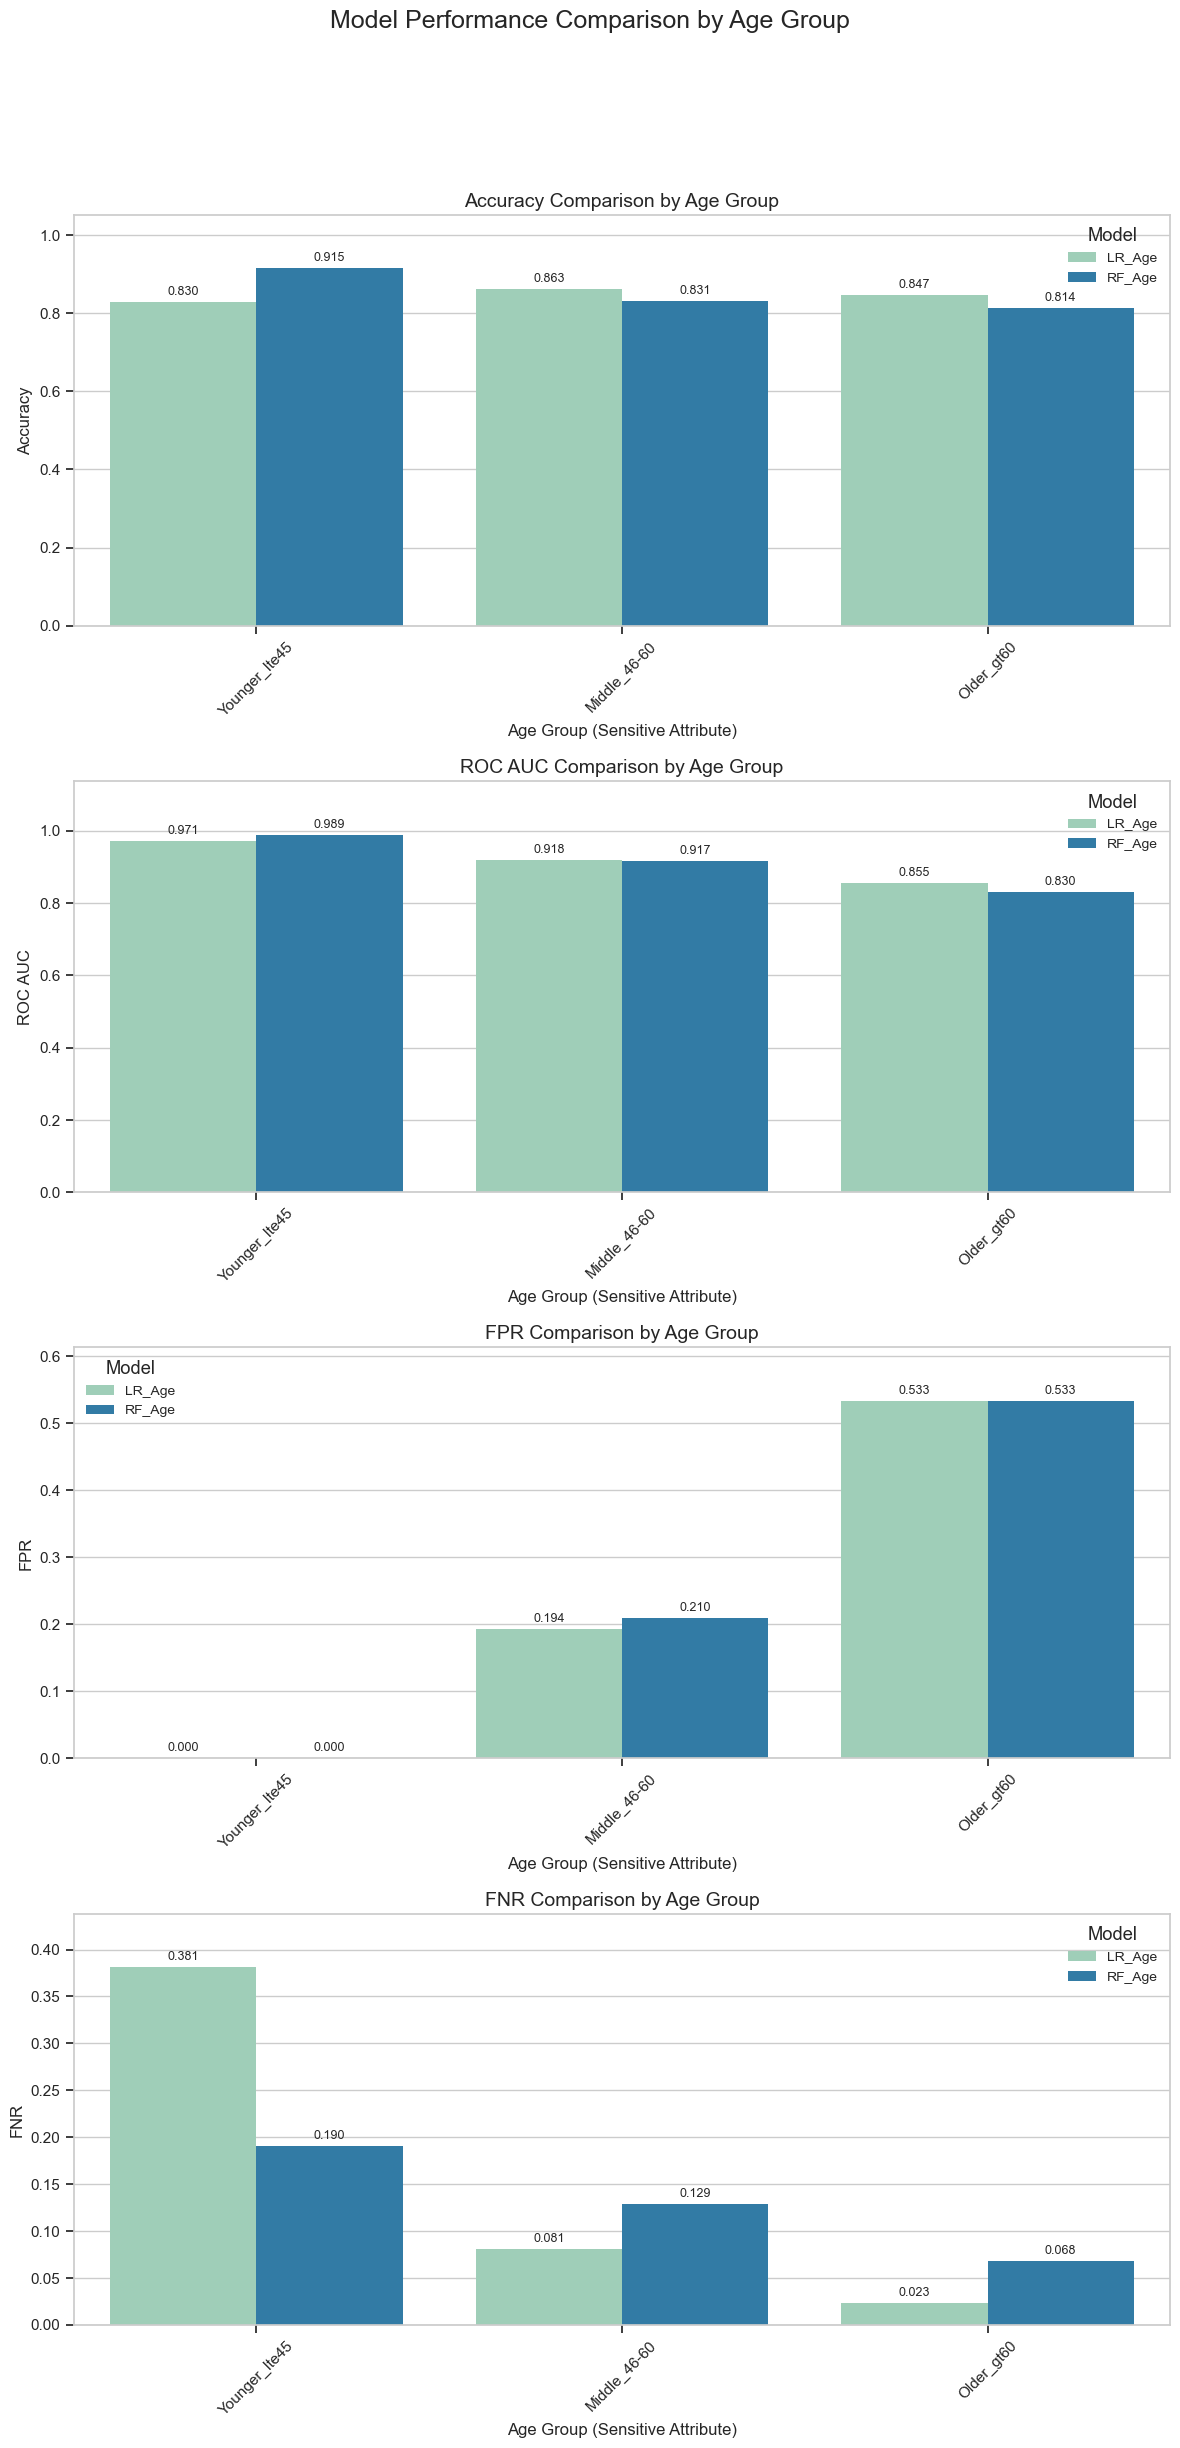


--- Part 3: Bias Analysis (Subgroup Performance for Age Groups) (Corrected) Finished ---


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For plotting styles
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix # Already imported
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid') # Consistent styling
sns.set_context("notebook", font_scale=1.1)

# --- Assume variables from Part 1 & Part 2 (Age Analysis) are available: ---
# y_test_series_age (true labels for the test set)
# y_pred_log_reg_age, y_prob_log_reg_age (Logistic Regression predictions)
# y_pred_rand_forest_age, y_prob_rand_forest_age (Random Forest predictions)
# X_test_sensitive_age_group (Series with 'age_group' labels for the test set)
# SENSITIVE_ATTRIBUTE_AGE (string, should be 'age_group')

# For this part to be runnable if prior variables aren't in the active environment,
# comprehensive placeholders would be needed.
# We'll proceed assuming Part 1 and 2 (Age Analysis) have been run successfully.

if ('y_test_series_age' not in locals() or
    'y_pred_log_reg_age' not in locals() or 'y_prob_log_reg_age' not in locals() or
    'y_pred_rand_forest_age' not in locals() or 'y_prob_rand_forest_age' not in locals() or
    'X_test_sensitive_age_group' not in locals() or 'SENSITIVE_ATTRIBUTE_AGE' not in locals()):
    print("Error: Essential variables from Part 1 or 2 (Age Analysis) not found. Please run them first.")
    print("Using minimal dummy data for demonstration purposes ONLY for Part 3 (Age Analysis).")
    _n_test_samples_age = 75
    SENSITIVE_ATTRIBUTE_AGE = 'age_group'
    age_labels_standin = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']
    X_test_sensitive_age_group = pd.Series(np.random.choice(age_labels_standin, _n_test_samples_age))
    y_test_series_age = pd.Series(np.random.randint(0, 2, _n_test_samples_age), name='target', index=X_test_sensitive_age_group.index)
    y_pred_log_reg_age = np.random.randint(0, 2, _n_test_samples_age)
    y_prob_log_reg_age = np.random.rand(_n_test_samples_age)
    y_pred_rand_forest_age = np.random.randint(0, 2, _n_test_samples_age)
    y_prob_rand_forest_age = np.random.rand(_n_test_samples_age)
else:
    print("Using variables from Part 1 & 2 (Age Analysis) for Bias Analysis.")


print("\n--- Part 3: Bias Analysis (Subgroup Performance for Age Groups) (Corrected)---")

# --- 1. Define Helper Function (if not already defined in the session) ---
if 'evaluate_subgroup_performance' not in locals():
    print("Defining helper function 'evaluate_subgroup_performance'...")
    def evaluate_subgroup_performance(y_true_full, y_pred_full, y_prob_full, subgroup_mask, subgroup_name, model_name):
        y_true_sub = y_true_full[subgroup_mask]
        y_pred_sub = np.asarray(y_pred_full)[subgroup_mask]
        y_prob_sub = np.asarray(y_prob_full)[subgroup_mask]

        if len(y_true_sub) == 0:
            print(f"\nNo samples for {subgroup_name} ({model_name}) in the test set.")
            return None

        accuracy = accuracy_score(y_true_sub, y_pred_sub)
        roc_auc = roc_auc_score(y_true_sub, y_prob_sub) if len(np.unique(y_true_sub)) > 1 else np.nan
        cm = confusion_matrix(y_true_sub, y_pred_sub)

        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        elif cm.size == 1 and len(y_true_sub) > 0:
            actual_class = y_true_sub.iloc[0] if isinstance(y_true_sub, pd.Series) else y_true_sub[0]
            predicted_class = y_pred_sub[0]
            if actual_class == 0 and predicted_class == 0: tn, fp, fn, tp = len(y_true_sub), 0, 0, 0
            elif actual_class == 1 and predicted_class == 1: tn, fp, fn, tp = 0, 0, 0, len(y_true_sub)
            elif actual_class == 0 and predicted_class == 1: tn, fp, fn, tp = 0, len(y_true_sub), 0, 0
            elif actual_class == 1 and predicted_class == 0: tn, fp, fn, tp = 0, 0, len(y_true_sub), 0
            else: tn, fp, fn, tp = 0,0,0,0
        else:
            tn, fp, fn, tp = 0, 0, 0, 0
            tp = np.sum((y_true_sub == 1) & (y_pred_sub == 1))
            tn = np.sum((y_true_sub == 0) & (y_pred_sub == 0))
            fp = np.sum((y_true_sub == 0) & (y_pred_sub == 1))
            fn = np.sum((y_true_sub == 1) & (y_pred_sub == 0))
            print(f"Warning: Confusion matrix for {subgroup_name} ({model_name}) was not standard 2x2: {cm}. Recalculated TN/FP/FN/TP.")

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

        print(f"\n--- {model_name} Evaluation for Age Group: {subgroup_name} ---")
        print(f"Test Samples: {len(y_true_sub)}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}" if not pd.isna(roc_auc) else "ROC AUC: N/A")
        print(f"FPR (Type I Error): {fpr:.4f}")
        print(f"FNR (Type II Error): {fnr:.4f}")

        return {
            'Subgroup': subgroup_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'ROC AUC': roc_auc,
            'FPR': fpr,
            'FNR': fnr,
            'Samples': len(y_true_sub)
        }

# --- 2. Define Age Groups and Evaluate ---
age_group_categories = X_test_sensitive_age_group.unique()
# If you defined specific age_labels in Part 1 and want to maintain that order:
# age_group_order = ['Younger_lte45', 'Middle_46-60', 'Older_gt60'] # from Part 1
# age_group_categories = [cat for cat in age_group_order if cat in age_group_categories]


bias_results_performance_age = []

print("\n" + "="*30 + "\nBias Analysis (Performance): Logistic Regression for Age Groups\n" + "="*30)
if y_pred_log_reg_age is not None:
    for age_cat in age_group_categories:
        subgroup_mask_age = (X_test_sensitive_age_group == age_cat)
        if subgroup_mask_age.sum() > 0 :
            lr_metrics_age = evaluate_subgroup_performance(
                y_test_series_age, y_pred_log_reg_age, y_prob_log_reg_age,
                subgroup_mask_age, age_cat, 'LR_Age'
            )
            if lr_metrics_age: bias_results_performance_age.append(lr_metrics_age)
else:
    print("Skipping Logistic Regression (Age Analysis) subgroup evaluation as predictions are not available.")

print("\n" + "="*30 + "\nBias Analysis (Performance): Random Forest for Age Groups\n" + "="*30)
if y_pred_rand_forest_age is not None:
    for age_cat in age_group_categories:
        subgroup_mask_age = (X_test_sensitive_age_group == age_cat)
        if subgroup_mask_age.sum() > 0 :
            rf_metrics_age = evaluate_subgroup_performance(
                y_test_series_age, y_pred_rand_forest_age, y_prob_rand_forest_age,
                subgroup_mask_age, age_cat, 'RF_Age'
            )
            if rf_metrics_age: bias_results_performance_age.append(rf_metrics_age)
else:
    print("Skipping Random Forest (Age Analysis) subgroup evaluation as predictions are not available.")

bias_performance_df_age = pd.DataFrame(bias_results_performance_age)

if not bias_performance_df_age.empty:
    print("\n\n--- Summary of Subgroup Performance Analysis (Age Groups) ---")
    # Ensure consistent order for plotting if you have predefined age_labels from Part 1
    # Example: age_labels = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']
    # If 'age_labels' is defined, use it for ordering:
    if 'age_labels' in locals() and age_labels is not None:
         bias_performance_df_age['Subgroup'] = pd.Categorical(bias_performance_df_age['Subgroup'], categories=age_labels, ordered=True)
         bias_performance_df_age.sort_values(by=['Model', 'Subgroup'], inplace=True)
         subgroup_order_for_plot = age_labels
    else: # Otherwise, use unique categories found, sorted alphabetically/numerically
        subgroup_order_for_plot = sorted(bias_performance_df_age['Subgroup'].unique())

    print(bias_performance_df_age.to_string())

    # --- 4. Visualize Bias Metrics for Age Groups ---
    metrics_to_plot_age = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    num_metrics_age = len(metrics_to_plot_age)
    plot_df_age = bias_performance_df_age.dropna(subset=metrics_to_plot_age, how='all')

    if not plot_df_age.empty:
        fig_age, axes_age = plt.subplots(num_metrics_age, 1, figsize=(12, 6 * num_metrics_age), sharex=False)
        if num_metrics_age == 1: axes_age = [axes_age]

        fig_age.suptitle('Model Performance Comparison by Age Group', fontsize=18, y=1.02)

        for i, metric in enumerate(metrics_to_plot_age):
            current_plot_data = plot_df_age.dropna(subset=[metric])
            if not current_plot_data.empty:
                sns.barplot(data=current_plot_data, x='Subgroup', y=metric, hue='Model', ax=axes_age[i], palette='YlGnBu', order=subgroup_order_for_plot)
                axes_age[i].set_title(f'{metric} Comparison by Age Group', fontsize=14)
                axes_age[i].set_xlabel('Age Group (Sensitive Attribute)', fontsize=12)
                axes_age[i].set_ylabel(metric, fontsize=12)
                axes_age[i].legend(title='Model', loc='best', fontsize=10)
                # CORRECTED LINE: Removed 'ha' parameter
                axes_age[i].tick_params(axis='x', rotation=45, labelsize=11)
                axes_age[i].tick_params(axis='y', labelsize=11)

                for container in axes_age[i].containers:
                    axes_age[i].bar_label(container, fmt='%.3f', fontsize=9, padding=3)
                axes_age[i].margins(y=0.15)
            else:
                axes_age[i].text(0.5, 0.5, f"No data to plot for {metric}", ha='center', va='center', transform=axes_age[i].transAxes)
                axes_age[i].set_title(f'{metric} Comparison by Age Group (No Data)', fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    else:
        print("\nCannot generate bias metric plots for age groups: DataFrame is empty or all relevant values are NaN after dropping.")
else:
    print("\nNo performance bias results generated for age groups, likely due to empty subgroups or errors.")

print("\n--- Part 3: Bias Analysis (Subgroup Performance for Age Groups) (Corrected) Finished ---")

Using variables from Parts 1-3 (Age Analysis) for Fairness Analysis (DP & EOpp).

--- Part 4: Fairness Analysis (Demographic Parity & Equal Opportunity for Age Groups) (Corrected) ---

Fairness Analysis (DP & EOpp) by Age Group: Logistic Regression (LR_Age)

--- Fairness Metrics: LR_Age for Age Group: Younger_lte45 ---
Samples in group: 47
Positive Prediction Rate (Demographic Parity): 0.2766
True Positive Rate (Equal Opportunity): 0.6190

--- Fairness Metrics: LR_Age for Age Group: Middle_46-60 ---
Samples in group: 124
Positive Prediction Rate (Demographic Parity): 0.5565
True Positive Rate (Equal Opportunity): 0.9194

--- Fairness Metrics: LR_Age for Age Group: Older_gt60 ---
Samples in group: 59
Positive Prediction Rate (Demographic Parity): 0.8644
True Positive Rate (Equal Opportunity): 0.9773

Fairness Analysis (DP & EOpp) by Age Group: Random Forest (RF_Age)

--- Fairness Metrics: RF_Age for Age Group: Younger_lte45 ---
Samples in group: 47
Positive Prediction Rate (Demographic 

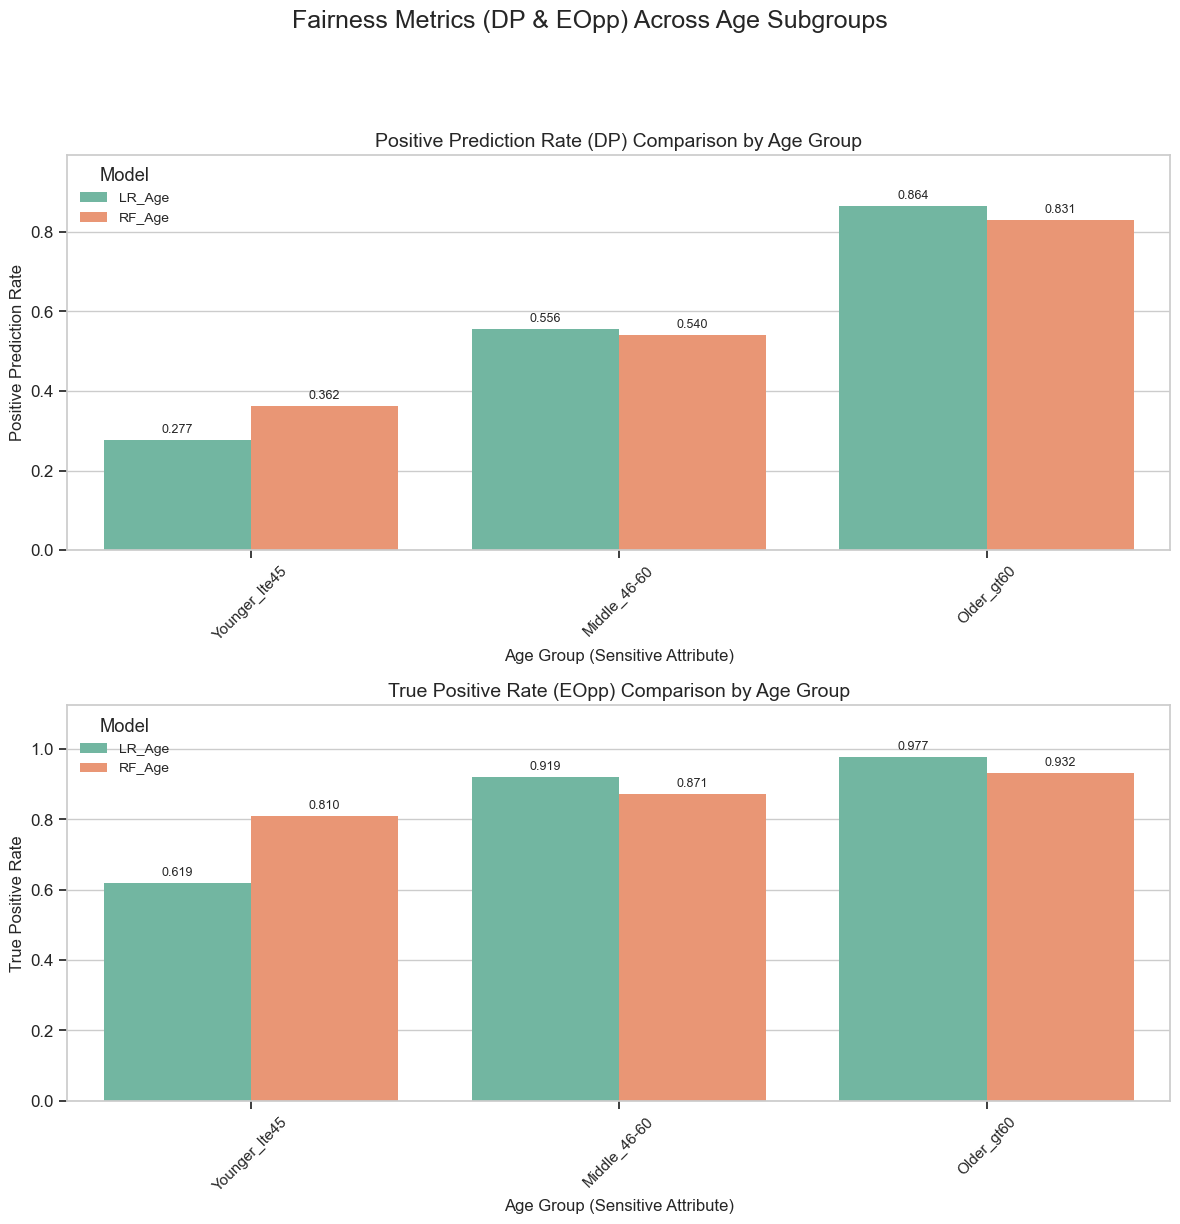


--- Part 4: Fairness Analysis (Demographic Parity & Equal Opportunity for Age Groups) (Corrected) Finished ---


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For plotting styles
from sklearn.metrics import confusion_matrix # For TPR calculation within helper if needed
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid') # Consistent styling
sns.set_context("notebook", font_scale=1.1)

# --- Assume variables from Part 1, 2 & 3 (Age Analysis) are available: ---
# y_test_series_age (true labels for the test set)
# y_pred_log_reg_age (Logistic Regression predicted labels for age analysis)
# y_pred_rand_forest_age (Random Forest predicted labels for age analysis)
# X_test_sensitive_age_group (Series with 'age_group' labels for the test set)
# SENSITIVE_ATTRIBUTE_AGE (string, should be 'age_group')
# POSITIVE_CLASS_LABEL (should be 1)
# age_labels (list of age group names in desired order, if defined in Part 1)


# For this part to be runnable if prior variables aren't in the active environment,
# comprehensive placeholders would be needed.
# We'll proceed assuming Parts 1-3 (Age Analysis) have been run successfully.

if ('y_test_series_age' not in locals() or
    'y_pred_log_reg_age' not in locals() or
    'y_pred_rand_forest_age' not in locals() or
    'X_test_sensitive_age_group' not in locals() or
    'SENSITIVE_ATTRIBUTE_AGE' not in locals()
    ):
    print("Error: Essential variables from Parts 1-3 (Age Analysis) not found. Please run them first.")
    print("Using minimal dummy data for demonstration purposes ONLY for Part 4 (Age Analysis).")
    _n_test_samples_age = 75
    SENSITIVE_ATTRIBUTE_AGE = 'age_group'
    age_labels_standin = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']
    X_test_sensitive_age_group = pd.Series(np.random.choice(age_labels_standin, _n_test_samples_age))
    y_test_series_age = pd.Series(np.random.randint(0, 2, _n_test_samples_age), name='target', index=X_test_sensitive_age_group.index)
    y_pred_log_reg_age = np.random.randint(0, 2, _n_test_samples_age)
    y_pred_rand_forest_age = np.random.randint(0, 2, _n_test_samples_age)
    POSITIVE_CLASS_LABEL = 1
    age_labels = age_labels_standin # for plotting order
else:
    print("Using variables from Parts 1-3 (Age Analysis) for Fairness Analysis (DP & EOpp).")
    if 'POSITIVE_CLASS_LABEL' not in locals():
        POSITIVE_CLASS_LABEL = 1 # Default if not carried over
    # if 'age_labels' was defined in Part 1 for specific ordering, it should be available.
    # If not, it will be handled in the plotting section.


print("\n--- Part 4: Fairness Analysis (Demographic Parity & Equal Opportunity for Age Groups) (Corrected) ---")

# --- 1. Define Helper Function (if not already defined in the session) ---
if 'calculate_fairness_metrics_dp_eopp' not in locals():
    print("Defining helper function 'calculate_fairness_metrics_dp_eopp'...")
    def calculate_fairness_metrics_dp_eopp(y_true_full, y_pred_labels_full, group_mask, subgroup_name, model_name):
        y_true_sub = y_true_full[group_mask]
        y_pred_labels_sub = np.asarray(y_pred_labels_full)[group_mask]
        num_samples = len(y_true_sub)

        if num_samples == 0:
            return None

        positive_prediction_rate = np.mean(y_pred_labels_sub == POSITIVE_CLASS_LABEL)
        actual_positives_in_subgroup_mask = (y_true_sub == POSITIVE_CLASS_LABEL)
        num_actual_positives_sub = np.sum(actual_positives_in_subgroup_mask)

        if num_actual_positives_sub == 0:
            true_positive_rate = np.nan
        else:
            predicted_positives_for_actual_positives_sub = y_pred_labels_sub[actual_positives_in_subgroup_mask]
            true_positive_rate = np.mean(predicted_positives_for_actual_positives_sub == POSITIVE_CLASS_LABEL)

        print(f"\n--- Fairness Metrics: {model_name} for Age Group: {subgroup_name} ---")
        print(f"Samples in group: {num_samples}")
        print(f"Positive Prediction Rate (Demographic Parity): {positive_prediction_rate:.4f}")
        print(f"True Positive Rate (Equal Opportunity): {true_positive_rate:.4f}" if not pd.isna(true_positive_rate) else "True Positive Rate (Equal Opportunity): N/A (No actual positives in subgroup)")

        return {
            'Subgroup': subgroup_name,
            'Model': model_name,
            'Samples': num_samples,
            'Positive Prediction Rate (DP)': positive_prediction_rate,
            'True Positive Rate (EOpp)': true_positive_rate
        }

# --- 2. Calculate Fairness Metrics for Each Age Group and Model ---
fairness_results_age_dp_eopp = []
age_group_categories = X_test_sensitive_age_group.unique()
# If 'age_labels' (the predefined order) exists from Part 1, prefer that for iteration order
if 'age_labels' in locals() and age_labels is not None:
    ordered_age_group_categories = [label for label in age_labels if label in age_group_categories]
    # Add any unique categories found in data but not in predefined age_labels (should not happen if binning is exhaustive)
    for cat in age_group_categories:
        if cat not in ordered_age_group_categories:
            ordered_age_group_categories.append(cat)
    age_group_categories_to_iterate = ordered_age_group_categories
else:
    age_group_categories_to_iterate = sorted(list(age_group_categories))


print("\n" + "="*30 + "\nFairness Analysis (DP & EOpp) by Age Group: Logistic Regression (LR_Age)\n" + "="*30)
if y_pred_log_reg_age is not None:
    for age_cat in age_group_categories_to_iterate:
        mask_age = (X_test_sensitive_age_group == age_cat)
        if mask_age.sum() > 0:
            metrics = calculate_fairness_metrics_dp_eopp(y_test_series_age, y_pred_log_reg_age, mask_age, age_cat, 'LR_Age')
            if metrics: fairness_results_age_dp_eopp.append(metrics)
else:
    print("Skipping LR_Age fairness metrics as predictions are not available.")

print("\n" + "="*30 + "\nFairness Analysis (DP & EOpp) by Age Group: Random Forest (RF_Age)\n" + "="*30)
if y_pred_rand_forest_age is not None:
    for age_cat in age_group_categories_to_iterate:
        mask_age = (X_test_sensitive_age_group == age_cat)
        if mask_age.sum() > 0:
            metrics = calculate_fairness_metrics_dp_eopp(y_test_series_age, y_pred_rand_forest_age, mask_age, age_cat, 'RF_Age')
            if metrics: fairness_results_age_dp_eopp.append(metrics)
else:
    print("Skipping RF_Age fairness metrics as predictions are not available.")

# --- 3. Compile, Display, and Analyze Disparities for Age Groups ---
fairness_dp_eopp_df_age = pd.DataFrame(fairness_results_age_dp_eopp)

if not fairness_dp_eopp_df_age.empty:
    # Order Subgroup factor for plotting if age_labels is defined
    if 'age_labels' in locals() and age_labels is not None:
        fairness_dp_eopp_df_age['Subgroup'] = pd.Categorical(fairness_dp_eopp_df_age['Subgroup'], categories=age_labels, ordered=True)
    fairness_dp_eopp_df_age.sort_values(by=['Model', 'Subgroup'], inplace=True)

    print("\n\n--- Summary of Fairness Analysis by Age Group (Demographic Parity & Equal Opportunity) ---")
    print(fairness_dp_eopp_df_age.to_string())

    print("\n--- Fairness Disparities Across Age Groups (Max Rate - Min Rate) ---")
    for model_name_iter in fairness_dp_eopp_df_age['Model'].unique():
        model_df_iter = fairness_dp_eopp_df_age[fairness_dp_eopp_df_age['Model'] == model_name_iter]
        
        dp_rates = model_df_iter['Positive Prediction Rate (DP)'].dropna()
        dp_disparity_age = dp_rates.max() - dp_rates.min() if not dp_rates.empty else np.nan
        
        eopp_rates = model_df_iter['True Positive Rate (EOpp)'].dropna()
        eopp_disparity_age = eopp_rates.max() - eopp_rates.min() if not eopp_rates.empty else np.nan

        print(f"\n{model_name_iter}:")
        print(f"  Demographic Parity Disparity (Max - Min PPR across age groups): {dp_disparity_age:+.4f}" if not pd.isna(dp_disparity_age) else "  Demographic Parity Disparity: N/A")
        print(f"  Equal Opportunity Disparity (Max - Min TPR across age groups): {eopp_disparity_age:+.4f}" if not pd.isna(eopp_disparity_age) else "  Equal Opportunity Disparity: N/A")
else:
    print("\nNo fairness results (DP & EOpp) generated for age groups.")

# --- 4. Visualize Fairness Metrics for Age Groups ---
if not fairness_dp_eopp_df_age.empty:
    fairness_metrics_to_plot_age = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    num_fairness_metrics_age_plot = len(fairness_metrics_to_plot_age)
    plot_df_dp_eopp_age = fairness_dp_eopp_df_age.dropna(subset=fairness_metrics_to_plot_age, how='all')

    if not plot_df_dp_eopp_age.empty:
        subgroup_order_for_plot_age = age_labels if 'age_labels' in locals() and age_labels is not None and isinstance(plot_df_dp_eopp_age['Subgroup'].dtype, pd.CategoricalDtype) else sorted(plot_df_dp_eopp_age['Subgroup'].unique())

        fig_fairness_age, axes_fairness_age = plt.subplots(num_fairness_metrics_age_plot, 1, figsize=(12, 6 * num_fairness_metrics_age_plot), sharex=False)
        if num_fairness_metrics_age_plot == 1: axes_fairness_age = [axes_fairness_age]

        fig_fairness_age.suptitle('Fairness Metrics (DP & EOpp) Across Age Subgroups', fontsize=18, y=1.02)

        for i, metric in enumerate(fairness_metrics_to_plot_age):
            ax = axes_fairness_age[i]
            current_metric_plot_df_age = plot_df_dp_eopp_age.dropna(subset=[metric])

            if not current_metric_plot_df_age.empty:
                sns.barplot(data=current_metric_plot_df_age, x='Subgroup', y=metric, hue='Model', ax=ax, palette='Set2', order=subgroup_order_for_plot_age)
                ax.set_title(f'{metric} Comparison by Age Group', fontsize=14)
                ax.set_xlabel('Age Group (Sensitive Attribute)', fontsize=12)
                ax.set_ylabel(metric.split('(')[0].strip(), fontsize=12)
                ax.legend(title='Model', loc='best', fontsize=10)
                # CORRECTED LINE: Removed 'ha' parameter
                ax.tick_params(axis='x', rotation=45, labelsize=11)

                for container in ax.containers:
                    labels = [f'{val:.3f}' if not pd.isna(val) else 'N/A' for val in container.datavalues]
                    ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
                ax.margins(y=0.15)
            else:
                ax.text(0.5, 0.5, f"No data to plot for {metric}", ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric} Comparison by Age Group (No Data)', fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    else:
        print("\nCannot generate fairness metric plots for age groups (DP & EOpp): DataFrame is empty or all relevant values are NaN after dropping.")
else:
    print("\nNo fairness results (DP & EOpp) compiled for age groups.")

print("\n--- Part 4: Fairness Analysis (Demographic Parity & Equal Opportunity for Age Groups) (Corrected) Finished ---")

Using combined DataFrames from Part 5 for plotting.


--- Visualizing Combined Subgroup Performance (Age Groups) (Corrected) ---


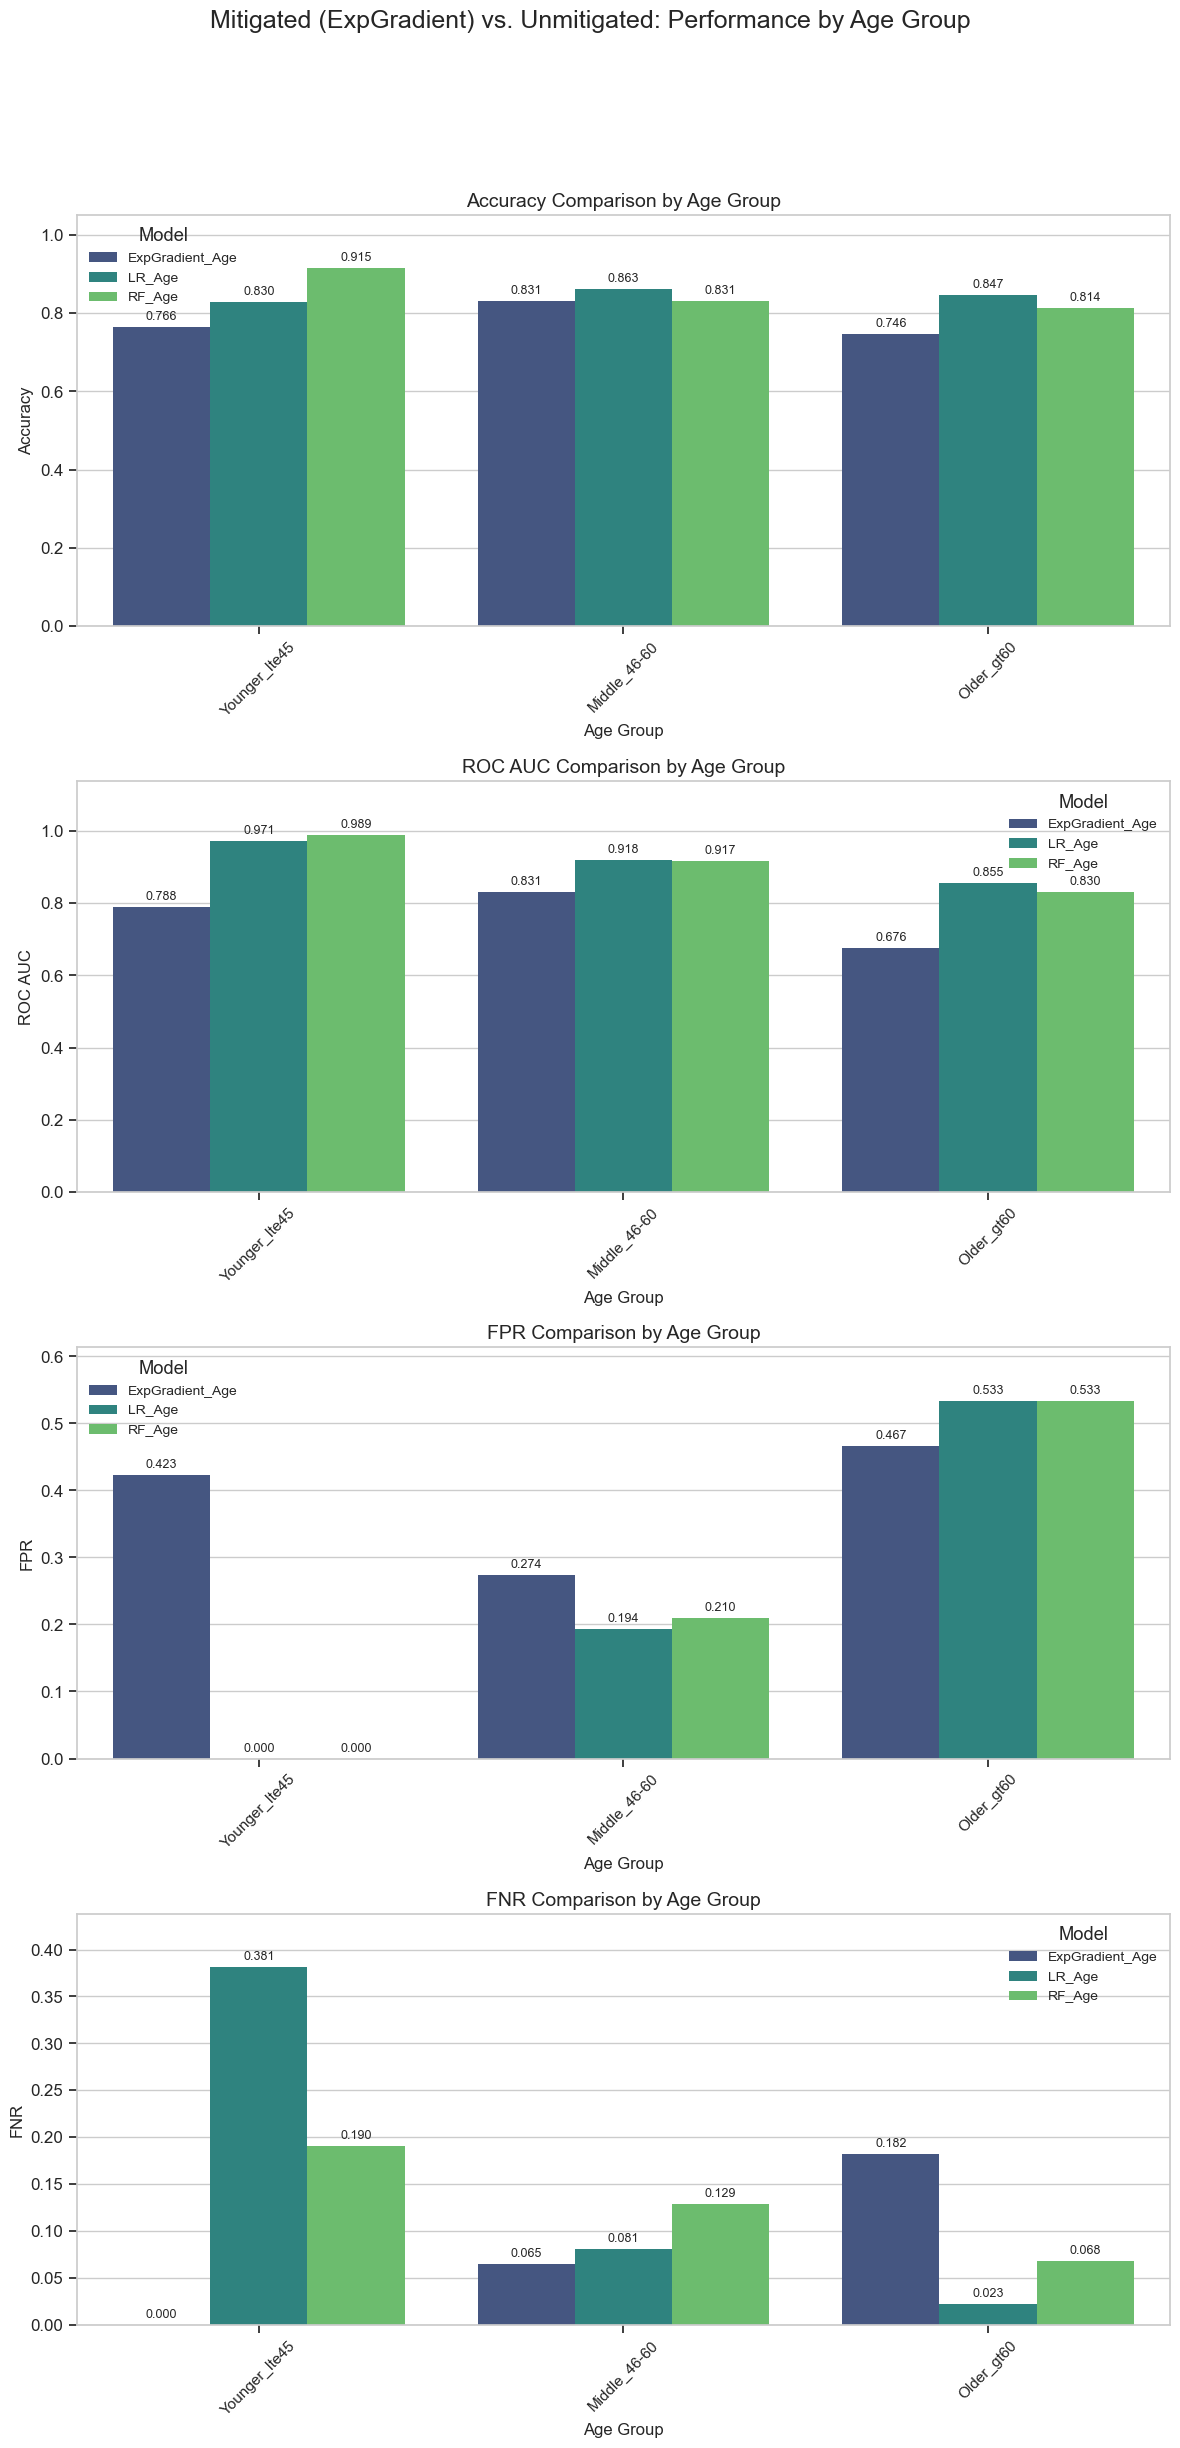



--- Visualizing Combined Fairness Metrics (DP & EOpp - Age Groups) (Corrected) ---


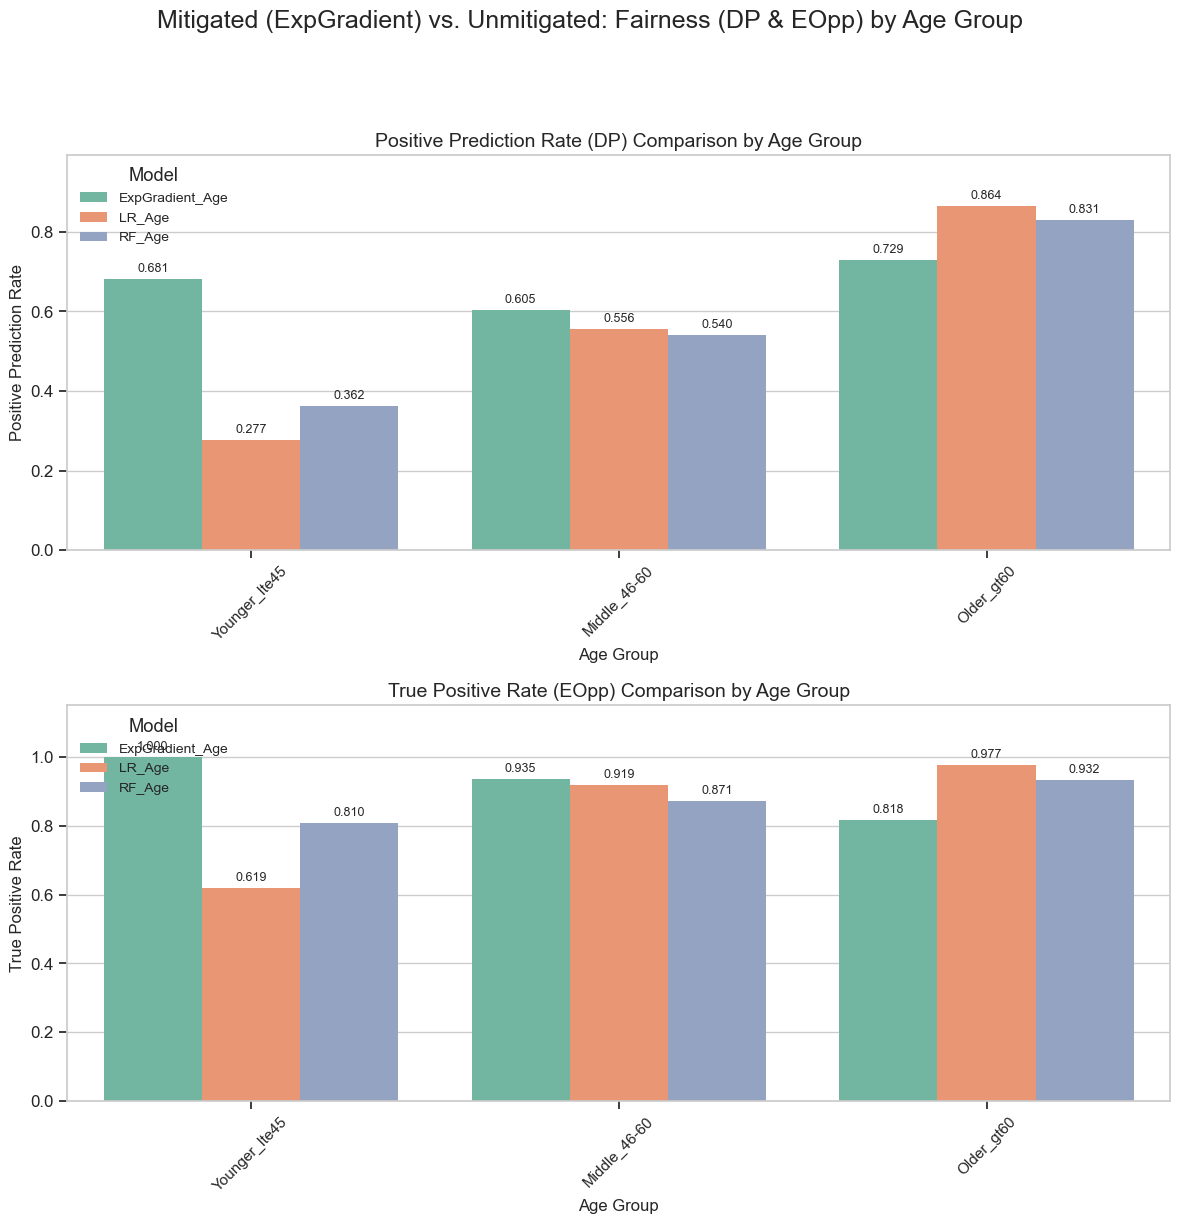


--- Corrected Plots for Part 5 (ExponentiatedGradient for Age Groups) Generated ---


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For plotting styles
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid') # Consistent styling
sns.set_context("notebook", font_scale=1.1)

# --- Assume variables from Part 5 (Age Analysis - ExpGradient) are available: ---
# combined_bias_performance_df_age (includes LR_Age, RF_Age, ExpGradient_Age)
# combined_fairness_dp_eopp_df_age (includes LR_Age, RF_Age, ExpGradient_Age)
# age_labels (list of age group names in desired order, if defined in Part 1)

# For this plotting code to be runnable if prior variables aren't in the active environment,
# comprehensive placeholders would be needed for the DataFrames.
# We'll proceed assuming Part 5 (Age Analysis - ExpGradient) has been run successfully.

if ('combined_bias_performance_df_age' not in locals() or
    'combined_fairness_dp_eopp_df_age' not in locals()):
    print("Error: 'combined_bias_performance_df_age' or 'combined_fairness_dp_eopp_df_age' not found.")
    print("Please ensure Part 5 (ExponentiatedGradient for Age Groups) has been run successfully.")
    # Fallback for demonstration (highly simplified and NOT FOR ANALYSIS)
    print("Using minimal dummy DataFrames for plotting demonstration purposes ONLY.")
    age_labels_standin = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']
    models_standin = ['LR_Age', 'RF_Age', 'ExpGradient_Age']
    bias_data_list = []
    fairness_data_list = []
    for model in models_standin:
        for group in age_labels_standin:
            bias_data_list.append({
                'Subgroup': group, 'Model': model, 'Accuracy': np.random.rand(),
                'ROC AUC': np.random.rand(), 'FPR': np.random.rand()*0.5,
                'FNR': np.random.rand()*0.5, 'Samples': np.random.randint(20,50)
            })
            fairness_data_list.append({
                'Subgroup': group, 'Model': model, 'Samples': np.random.randint(20,50),
                'Positive Prediction Rate (DP)': np.random.rand(),
                'True Positive Rate (EOpp)': np.random.rand() if np.random.rand() > 0.1 else np.nan
            })
    combined_bias_performance_df_age = pd.DataFrame(bias_data_list)
    combined_fairness_dp_eopp_df_age = pd.DataFrame(fairness_data_list)
    if 'age_labels' not in locals(): # Define for stand-in data
        age_labels = age_labels_standin
else:
    print("Using combined DataFrames from Part 5 for plotting.")
    # If age_labels was defined in Part 1 for specific ordering, it should be available.


# --- 1. Visualize Combined Subgroup Performance (Bias Metrics) for Age (Corrected) ---
if not combined_bias_performance_df_age.empty:
    print("\n\n--- Visualizing Combined Subgroup Performance (Age Groups) (Corrected) ---")
    metrics_to_plot_perf_age = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    num_metrics_perf_age = len(metrics_to_plot_perf_age)

    subgroup_order_perf = age_labels if 'age_labels' in locals() and age_labels is not None and isinstance(combined_bias_performance_df_age.get('Subgroup', pd.Series()).dtype, pd.CategoricalDtype) else sorted(combined_bias_performance_df_age['Subgroup'].unique())

    fig_perf_age_combined, axes_perf_age_combined = plt.subplots(num_metrics_perf_age, 1, figsize=(12, 6 * num_metrics_perf_age), sharex=False)
    if num_metrics_perf_age == 1: axes_perf_age_combined = [axes_perf_age_combined]

    fig_perf_age_combined.suptitle('Mitigated (ExpGradient) vs. Unmitigated: Performance by Age Group', fontsize=18, y=1.02)

    for i, metric in enumerate(metrics_to_plot_perf_age):
        ax = axes_perf_age_combined[i]
        plot_df_perf = combined_bias_performance_df_age.dropna(subset=[metric])
        if not plot_df_perf.empty:
            sns.barplot(data=plot_df_perf, x='Subgroup', y=metric, hue='Model', ax=ax, palette='viridis', order=subgroup_order_perf)
            ax.set_title(f'{metric} Comparison by Age Group', fontsize=14)
            ax.set_xlabel('Age Group', fontsize=12)
            ax.set_ylabel(metric, fontsize=12)
            ax.legend(title='Model', loc='best', fontsize=10)
            # CORRECTED LINE: Removed 'ha' parameter
            ax.tick_params(axis='x', rotation=45, labelsize=11)

            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', fontsize=9, padding=3)
            ax.margins(y=0.15)
        else:
            ax.text(0.5, 0.5, f"No data to plot for {metric}", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric} Comparison by Age Group (No Data)', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("No combined bias performance data for age groups to visualize.")

# --- 2. Visualize Combined Fairness Metrics (DP & EOpp) for Age (Corrected) ---
if not combined_fairness_dp_eopp_df_age.empty:
    print("\n\n--- Visualizing Combined Fairness Metrics (DP & EOpp - Age Groups) (Corrected) ---")
    metrics_to_plot_fairness_age = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    num_metrics_fairness_age = len(metrics_to_plot_fairness_age)

    subgroup_order_fairness = age_labels if 'age_labels' in locals() and age_labels is not None and isinstance(combined_fairness_dp_eopp_df_age.get('Subgroup', pd.Series()).dtype, pd.CategoricalDtype) else sorted(combined_fairness_dp_eopp_df_age['Subgroup'].unique())

    fig_fairness_age_combined, axes_fairness_age_combined = plt.subplots(num_metrics_fairness_age, 1, figsize=(12, 6 * num_metrics_fairness_age), sharex=False)
    if num_metrics_fairness_age == 1: axes_fairness_age_combined = [axes_fairness_age_combined]

    fig_fairness_age_combined.suptitle('Mitigated (ExpGradient) vs. Unmitigated: Fairness (DP & EOpp) by Age Group', fontsize=18, y=1.02)

    for i, metric in enumerate(metrics_to_plot_fairness_age):
        ax = axes_fairness_age_combined[i]
        plot_df_fairness = combined_fairness_dp_eopp_df_age.dropna(subset=[metric])
        if not plot_df_fairness.empty:
            sns.barplot(data=plot_df_fairness, x='Subgroup', y=metric, hue='Model', ax=ax, palette='Set2', order=subgroup_order_fairness)
            ax.set_title(f'{metric} Comparison by Age Group', fontsize=14)
            ax.set_xlabel('Age Group', fontsize=12)
            ax.set_ylabel(metric.split('(')[0].strip(), fontsize=12)
            ax.legend(title='Model', loc='best', fontsize=10)
            # CORRECTED LINE: Removed 'ha' parameter
            ax.tick_params(axis='x', rotation=45, labelsize=11)

            for container in ax.containers:
                labels = [f'{val:.3f}' if not pd.isna(val) else 'N/A' for val in container.datavalues]
                ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
            ax.margins(y=0.15)
        else:
            ax.text(0.5, 0.5, f"No data to plot for {metric}", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{metric} Comparison by Age Group (No Data)', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
else:
    print("No combined fairness (DP & EOpp) data for age groups to visualize.")

print("\n--- Corrected Plots for Part 5 (ExponentiatedGradient for Age Groups) Generated ---")

Using variables from Parts 1-5 (Age Analysis) for Mitigation with ThresholdOptimizer.

--- Part 6: Bias Mitigation with ThresholdOptimizer (for age_group) (Corrected Plotting) ---

--- Step 6.1: Setting up ThresholdOptimizer for age_group ---
Constraint for ThresholdOptimizer: equalized_odds
ThresholdOptimizer fitted for LR_Age.
Predictions made with ThresholdOptimizer for LR_Age (TO_LR_Age).
ThresholdOptimizer fitted for RF_Age.
Predictions made with ThresholdOptimizer for RF_Age (TO_RF_Age).

--- Step 6.3: Overall Evaluation of Threshold-Optimized Models (Age Analysis) ---

--- Overall Evaluation: TO_LR_Age ---
Accuracy: 0.8217
ROC AUC (Original LR_Age scores): 0.9114
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       103
           1       0.79      0.93      0.85       127

    accuracy                           0.82       230
   macro avg       0.84      0.81      0.81       230
weighted avg       0.83      0.82      0.82      

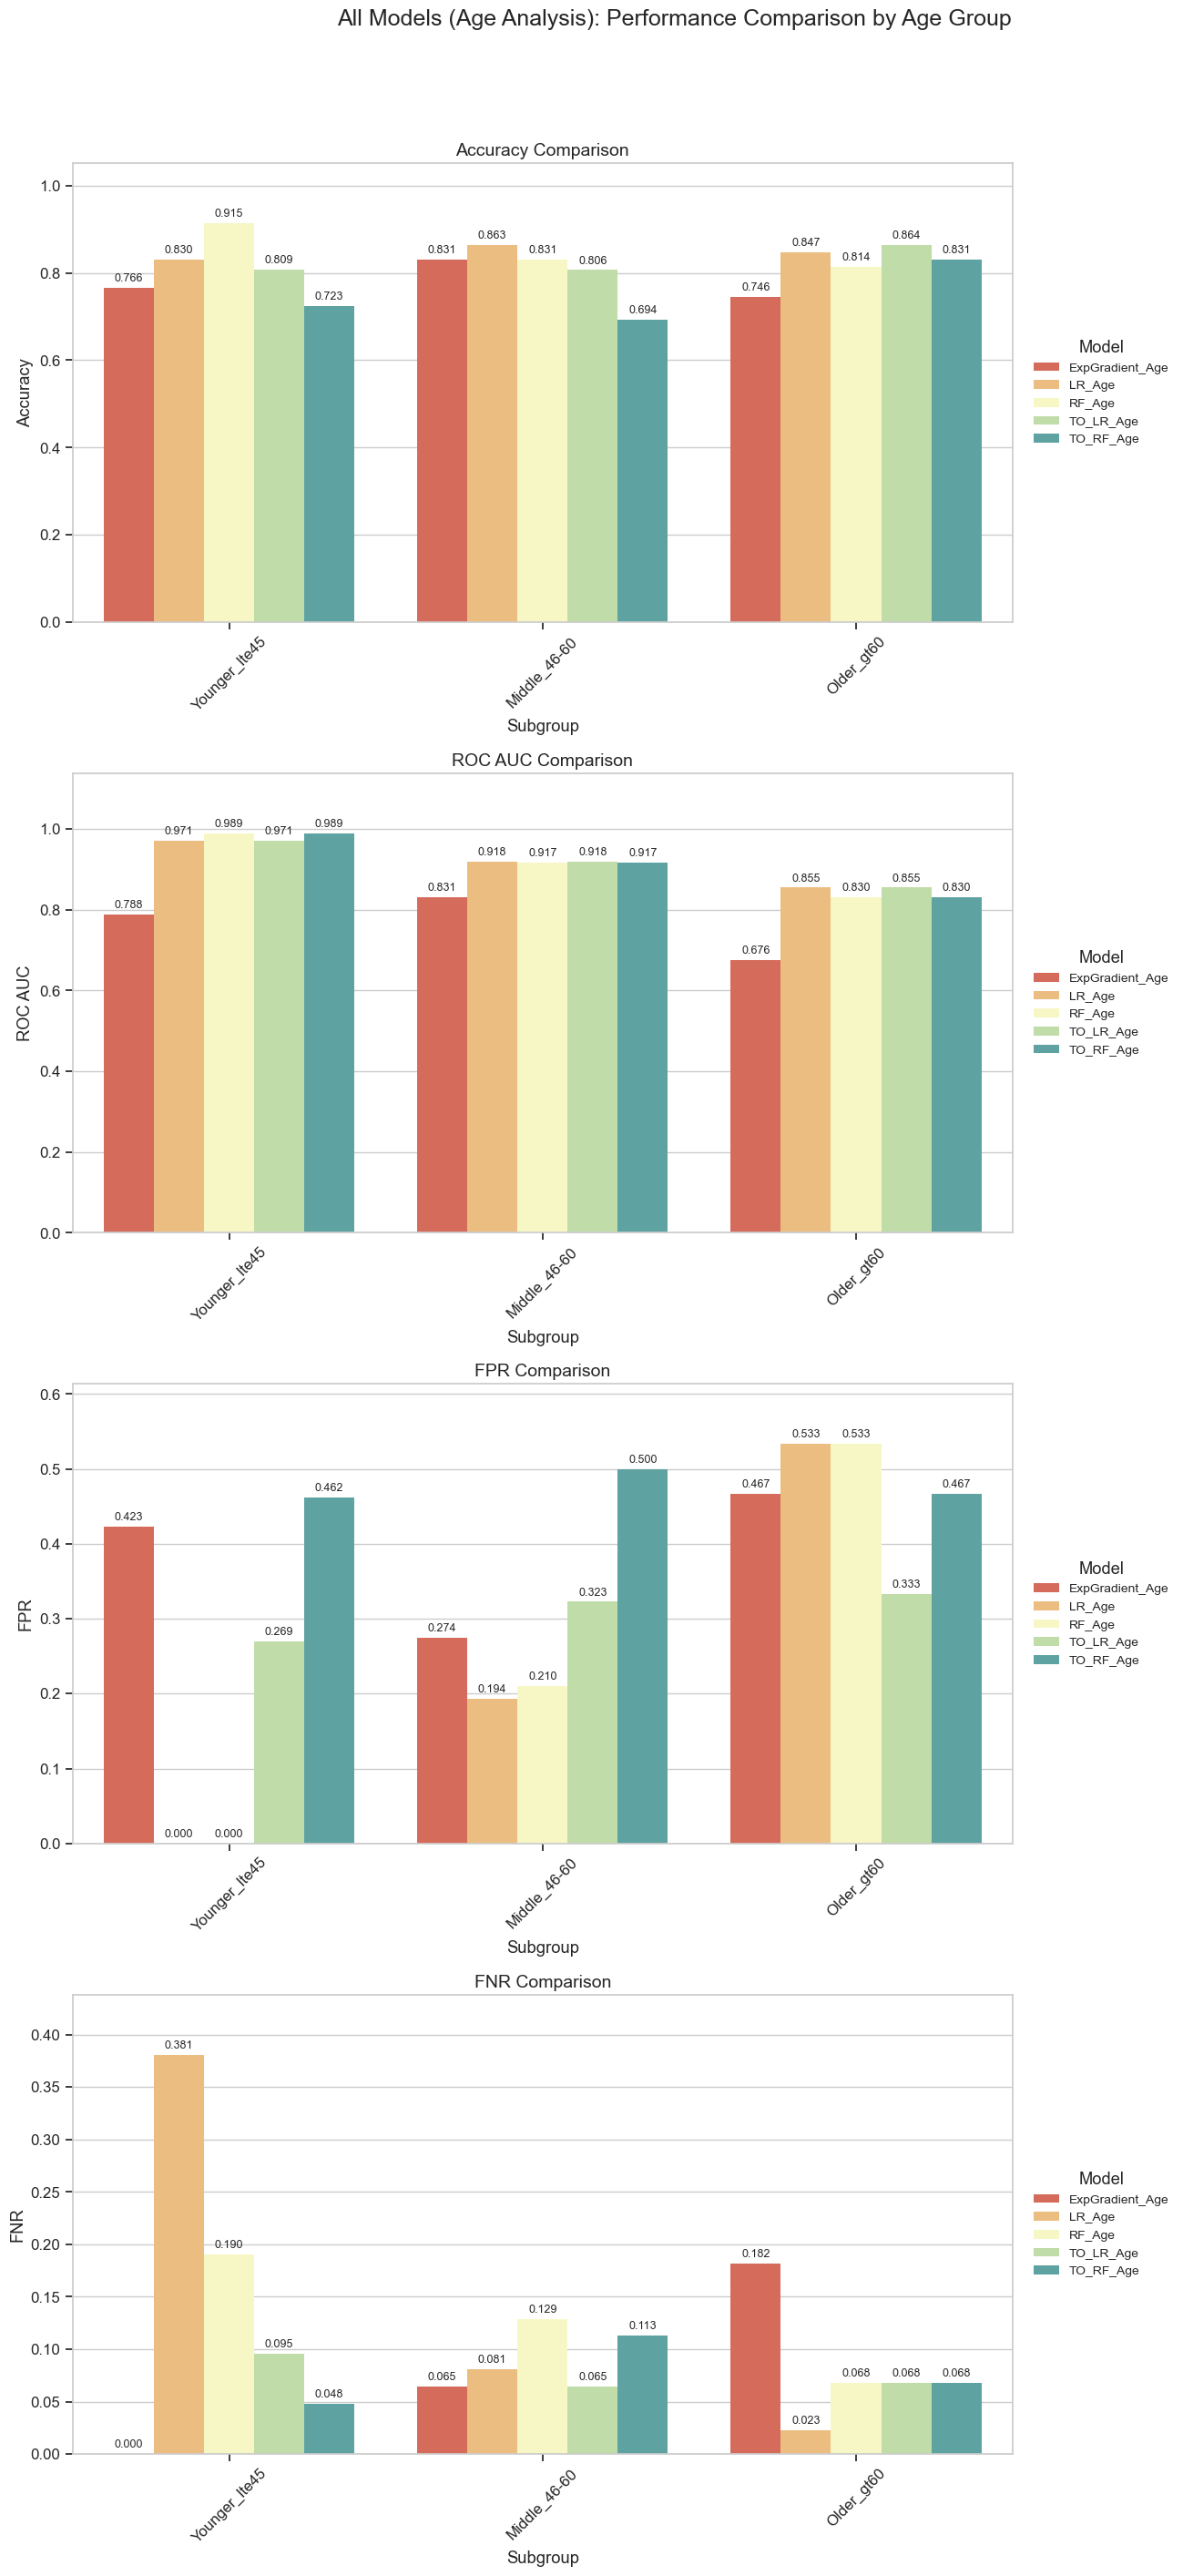



--- Final Expanded Summary of Fairness Metrics (DP & EOpp - All Models for Age) ---
         Subgroup            Model  Samples  Positive Prediction Rate (DP)  True Positive Rate (EOpp)
0   Younger_lte45  ExpGradient_Age       47                       0.680851                   1.000000
1    Middle_46-60  ExpGradient_Age      124                       0.604839                   0.935484
2      Older_gt60  ExpGradient_Age       59                       0.728814                   0.818182
3   Younger_lte45           LR_Age       47                       0.276596                   0.619048
4    Middle_46-60           LR_Age      124                       0.556452                   0.919355
5      Older_gt60           LR_Age       59                       0.864407                   0.977273
6   Younger_lte45           RF_Age       47                       0.361702                   0.809524
7    Middle_46-60           RF_Age      124                       0.540323                   0.870

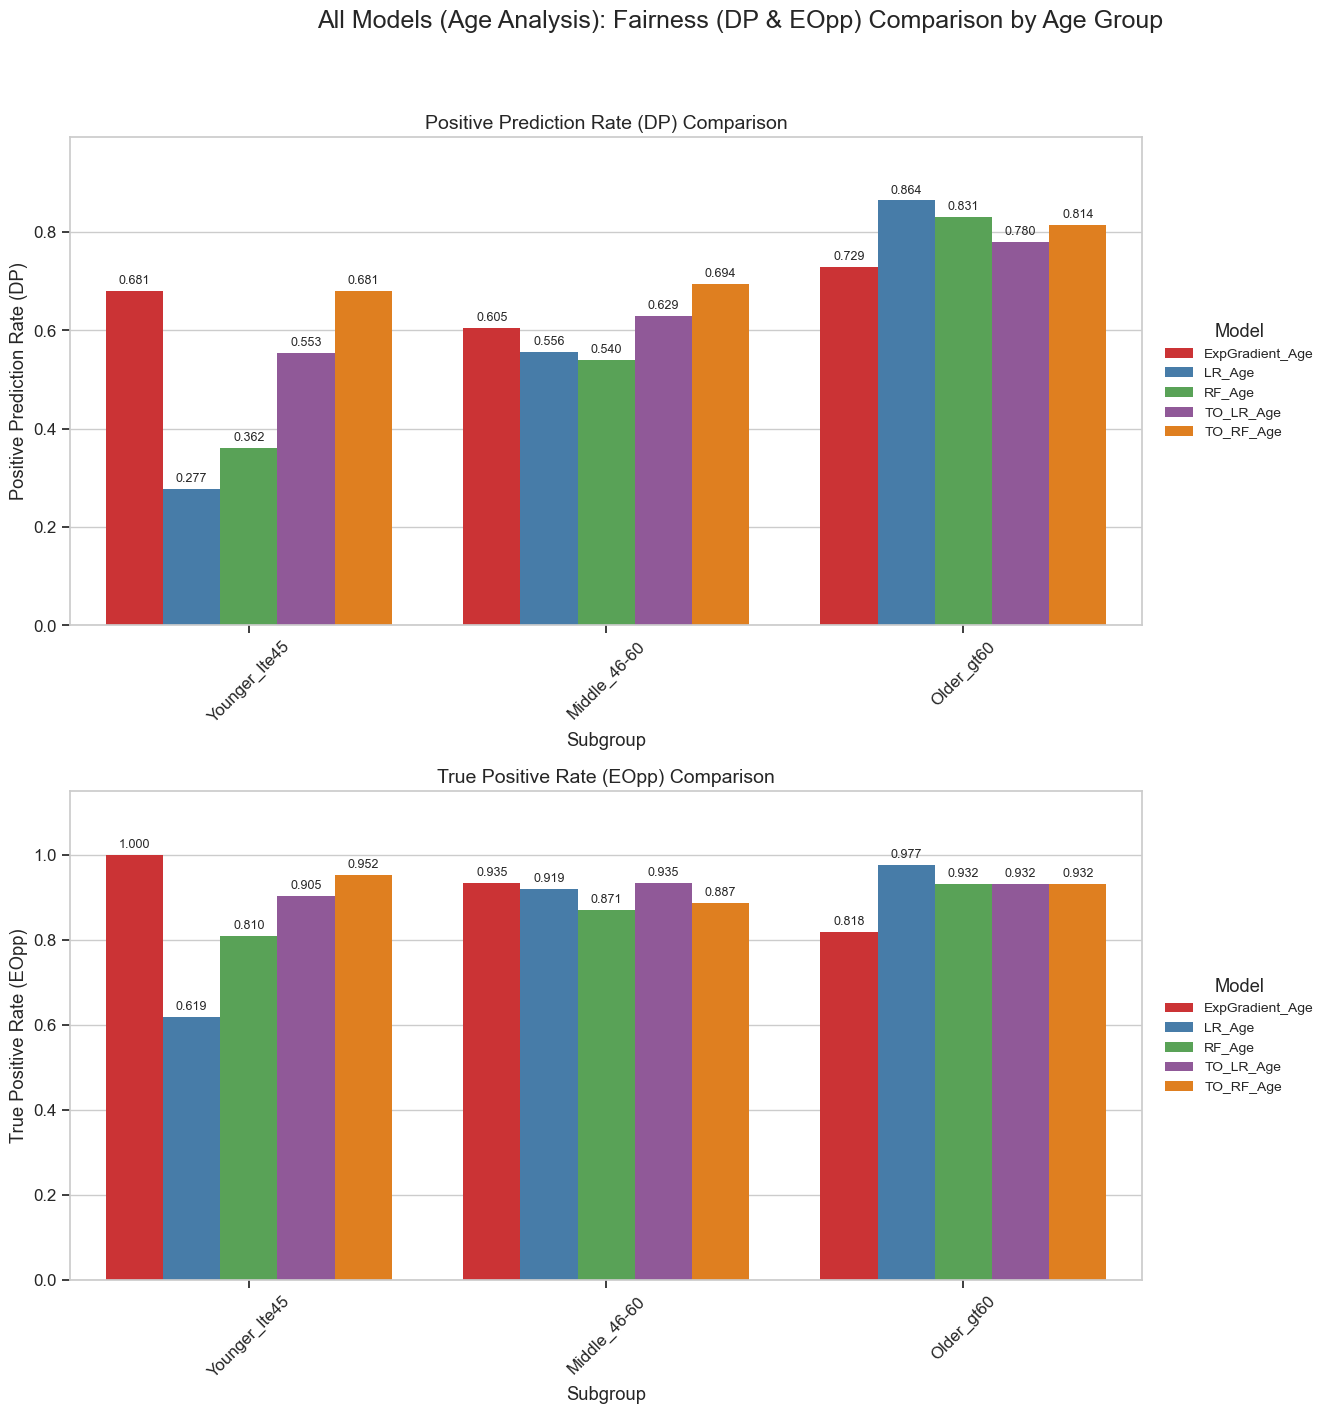


--- Part 6: Bias Mitigation with ThresholdOptimizer (for Age Groups) (Corrected Plotting) Finished ---

--- All analysis parts for 'age_group' as sensitive attribute are complete. ---


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from fairlearn.postprocessing import ThresholdOptimizer

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

# --- Assume variables from Parts 1-5 (Age Analysis) are available: ---
# Part 1: X_train_processed_age, X_test_processed_age, y_train
#         X_train_sensitive_age_group, X_test_sensitive_age_group
#         SENSITIVE_ATTRIBUTE_AGE (e.g., 'age_group')
#         age_labels (list of age group names in desired order, if defined)
# Part 2: log_reg_age, rand_forest_age (TRAINED unmitigated models for age)
#         y_prob_log_reg_age, y_prob_rand_forest_age (probabilities from unmitigated models)
# Part 3: evaluate_subgroup_performance (helper function - MUST BE DEFINED if in new session)
# Part 4: calculate_fairness_metrics_dp_eopp (helper function - MUST BE DEFINED if in new session)
#         POSITIVE_CLASS_LABEL
#         y_test_series_age (true labels for test set)
# Part 5: combined_bias_performance_df_age (includes LR_Age, RF_Age, ExpGradient_Age)
#         combined_fairness_dp_eopp_df_age (includes LR_Age, RF_Age, ExpGradient_Age)

# --- Placeholders if variables are not in locals (for standalone execution) ---
if ('log_reg_age' not in locals() or 'rand_forest_age' not in locals() or
    'y_prob_log_reg_age' not in locals() or 'y_prob_rand_forest_age' not in locals() or
    'y_test_series_age' not in locals() or 'X_test_sensitive_age_group' not in locals() or
    'SENSITIVE_ATTRIBUTE_AGE' not in locals() or 'X_test_processed_age' not in locals() or
    'combined_bias_performance_df_age' not in locals() or
    'combined_fairness_dp_eopp_df_age' not in locals()):
    print("Error: Essential variables from Parts 1-5 (Age Analysis) not found. Using dummy data.")
    _n_test_samples_age, _n_features_age = 75, 15
    SENSITIVE_ATTRIBUTE_AGE = 'age_group'
    age_labels_standin = ['Younger_lte45', 'Middle_46-60', 'Older_gt60']
    X_test_processed_age = np.random.rand(_n_test_samples_age, _n_features_age)
    y_test_series_age = pd.Series(np.random.randint(0, 2, _n_test_samples_age), name='target')
    X_test_sensitive_age_group = pd.Series(np.random.choice(age_labels_standin, _n_test_samples_age), index=y_test_series_age.index)
    y_prob_log_reg_age = np.random.rand(_n_test_samples_age)
    y_prob_rand_forest_age = np.random.rand(_n_test_samples_age)
    log_reg_age = LogisticRegression().fit(np.random.rand(10,2), np.random.randint(0,2,10))
    rand_forest_age = RandomForestClassifier().fit(np.random.rand(10,2), np.random.randint(0,2,10))
    # Initialize combined_ DFs with ExpGradient data if they are supposed to exist from Part 5
    models_standin_eg = ['LR_Age', 'RF_Age', 'ExpGradient_Age']
    bias_data_list_eg = []
    fairness_data_list_eg = []
    for model_eg in models_standin_eg:
        for group_eg in age_labels_standin:
            bias_data_list_eg.append({'Subgroup': group_eg, 'Model': model_eg, 'Accuracy': np.random.rand(), 'ROC AUC': np.random.rand(), 'FPR': np.random.rand()*0.4, 'FNR': np.random.rand()*0.4, 'Samples': np.random.randint(20,40)})
            fairness_data_list_eg.append({'Subgroup': group_eg, 'Model': model_eg, 'Samples': np.random.randint(20,40), 'Positive Prediction Rate (DP)': np.random.rand(), 'True Positive Rate (EOpp)': np.random.rand() if np.random.rand() > 0.1 else np.nan})
    combined_bias_performance_df_age = pd.DataFrame(bias_data_list_eg)
    combined_fairness_dp_eopp_df_age = pd.DataFrame(fairness_data_list_eg)

    if 'evaluate_subgroup_performance' not in locals():
        def evaluate_subgroup_performance(y_true_full, y_pred_full, y_prob_full, subgroup_mask, subgroup_name, model_name): return {'Subgroup': subgroup_name, 'Model': model_name, 'Accuracy': 0.5, 'ROC AUC': 0.5, 'FPR': 0.5, 'FNR': 0.5, 'Samples': subgroup_mask.sum()}
    if 'calculate_fairness_metrics_dp_eopp' not in locals():
        POSITIVE_CLASS_LABEL = 1
        def calculate_fairness_metrics_dp_eopp(y_true_full, y_pred_labels_full, group_mask, subgroup_name, model_name): return {'Subgroup': subgroup_name, 'Model': model_name, 'Samples': group_mask.sum(), 'Positive Prediction Rate (DP)': 0.5, 'True Positive Rate (EOpp)': 0.5}
    if 'POSITIVE_CLASS_LABEL' not in locals(): POSITIVE_CLASS_LABEL = 1
    if 'age_labels' not in locals(): age_labels = age_labels_standin
else:
    print("Using variables from Parts 1-5 (Age Analysis) for Mitigation with ThresholdOptimizer.")
    if 'POSITIVE_CLASS_LABEL' not in locals(): POSITIVE_CLASS_LABEL = 1

print(f"\n--- Part 6: Bias Mitigation with ThresholdOptimizer (for {SENSITIVE_ATTRIBUTE_AGE}) (Corrected Plotting) ---")

# --- 6.1: Setup ThresholdOptimizer ---
print(f"\n--- Step 6.1: Setting up ThresholdOptimizer for {SENSITIVE_ATTRIBUTE_AGE} ---")
constraint_string_to_age = "equalized_odds"
print(f"Constraint for ThresholdOptimizer: {constraint_string_to_age}")

# --- 6.2: Applying ThresholdOptimizer ---
optimizer_lr_age = ThresholdOptimizer(
    estimator=log_reg_age, constraints=constraint_string_to_age, objective="accuracy_score", prefit=True, predict_method='predict_proba'
)
y_pred_to_lr_age = None
try:
    optimizer_lr_age.fit(X_test_processed_age, y_test_series_age, sensitive_features=X_test_sensitive_age_group)
    print("ThresholdOptimizer fitted for LR_Age.")
    y_pred_to_lr_age = optimizer_lr_age.predict(X_test_processed_age, sensitive_features=X_test_sensitive_age_group)
    print("Predictions made with ThresholdOptimizer for LR_Age (TO_LR_Age).")
except Exception as e:
    print(f"Error fitting or predicting with ThresholdOptimizer for LR_Age: {e}")

optimizer_rf_age = ThresholdOptimizer(
    estimator=rand_forest_age, constraints=constraint_string_to_age, objective="accuracy_score", prefit=True, predict_method='predict_proba'
)
y_pred_to_rf_age = None
try:
    optimizer_rf_age.fit(X_test_processed_age, y_test_series_age, sensitive_features=X_test_sensitive_age_group)
    print("ThresholdOptimizer fitted for RF_Age.")
    y_pred_to_rf_age = optimizer_rf_age.predict(X_test_processed_age, sensitive_features=X_test_sensitive_age_group)
    print("Predictions made with ThresholdOptimizer for RF_Age (TO_RF_Age).")
except Exception as e:
    print(f"Error fitting or predicting with ThresholdOptimizer for RF_Age: {e}")

# --- 6.3: Overall Evaluation ---
print("\n--- Step 6.3: Overall Evaluation of Threshold-Optimized Models (Age Analysis) ---")
if y_pred_to_lr_age is not None:
    print("\n--- Overall Evaluation: TO_LR_Age ---")
    print(f"Accuracy: {accuracy_score(y_test_series_age, y_pred_to_lr_age):.4f}")
    if len(np.unique(y_test_series_age)) > 1: print(f"ROC AUC (Original LR_Age scores): {roc_auc_score(y_test_series_age, y_prob_log_reg_age):.4f}")
    print(classification_report(y_test_series_age, y_pred_to_lr_age, zero_division=0))
if y_pred_to_rf_age is not None:
    print("\n--- Overall Evaluation: TO_RF_Age ---")
    print(f"Accuracy: {accuracy_score(y_test_series_age, y_pred_to_rf_age):.4f}")
    if len(np.unique(y_test_series_age)) > 1: print(f"ROC AUC (Original RF_Age scores): {roc_auc_score(y_test_series_age, y_prob_rand_forest_age):.4f}")
    print(classification_report(y_test_series_age, y_pred_to_rf_age, zero_division=0))

# --- 6.4 & 6.5: Subgroup Performance and Fairness Metrics ---
to_lr_age_bias_metrics_list = []
to_lr_age_fairness_dp_eopp_list = []
to_rf_age_bias_metrics_list = []
to_rf_age_fairness_dp_eopp_list = []

age_group_categories_test = X_test_sensitive_age_group.unique()
ordered_age_cats_for_eval = age_labels if 'age_labels' in locals() and age_labels is not None and all(item in age_group_categories_test for item in age_labels) else sorted(list(age_group_categories_test))

if y_pred_to_lr_age is not None:
    print("\n" + "="*30 + f"\nBias & Fairness: TO_LR_Age (for {SENSITIVE_ATTRIBUTE_AGE})\n" + "="*30)
    for age_cat in ordered_age_cats_for_eval:
        if age_cat not in X_test_sensitive_age_group.values : continue
        subgroup_mask = (X_test_sensitive_age_group == age_cat)
        if subgroup_mask.sum() == 0: continue
        perf_metrics = evaluate_subgroup_performance(y_test_series_age, y_pred_to_lr_age, y_prob_log_reg_age, subgroup_mask, age_cat, 'TO_LR_Age')
        if perf_metrics: to_lr_age_bias_metrics_list.append(perf_metrics)
        fair_metrics = calculate_fairness_metrics_dp_eopp(y_test_series_age, y_pred_to_lr_age, subgroup_mask, age_cat, 'TO_LR_Age')
        if fair_metrics: to_lr_age_fairness_dp_eopp_list.append(fair_metrics)

if y_pred_to_rf_age is not None:
    print("\n" + "="*30 + f"\nBias & Fairness: TO_RF_Age (for {SENSITIVE_ATTRIBUTE_AGE})\n" + "="*30)
    for age_cat in ordered_age_cats_for_eval:
        if age_cat not in X_test_sensitive_age_group.values : continue
        subgroup_mask = (X_test_sensitive_age_group == age_cat)
        if subgroup_mask.sum() == 0: continue
        perf_metrics = evaluate_subgroup_performance(y_test_series_age, y_pred_to_rf_age, y_prob_rand_forest_age, subgroup_mask, age_cat, 'TO_RF_Age')
        if perf_metrics: to_rf_age_bias_metrics_list.append(perf_metrics)
        fair_metrics = calculate_fairness_metrics_dp_eopp(y_test_series_age, y_pred_to_rf_age, subgroup_mask, age_cat, 'TO_RF_Age')
        if fair_metrics: to_rf_age_fairness_dp_eopp_list.append(fair_metrics)

to_lr_bias_perf_df_age = pd.DataFrame(to_lr_age_bias_metrics_list)
to_lr_fairness_df_age = pd.DataFrame(to_lr_age_fairness_dp_eopp_list)
to_rf_bias_perf_df_age = pd.DataFrame(to_rf_age_bias_metrics_list)
to_rf_fairness_df_age = pd.DataFrame(to_rf_age_fairness_dp_eopp_list)

# --- 6.6: Comprehensive Comparison ---
print("\n--- Step 6.6: Comprehensive Comparison Including ThresholdOptimized Models (Age Analysis) ---")

if 'combined_bias_performance_df_age' not in locals(): combined_bias_performance_df_age = pd.DataFrame()
if not to_lr_bias_perf_df_age.empty:
    combined_bias_performance_df_age = pd.concat([combined_bias_performance_df_age, to_lr_bias_perf_df_age], ignore_index=True)
if not to_rf_bias_perf_df_age.empty:
    combined_bias_performance_df_age = pd.concat([combined_bias_performance_df_age, to_rf_bias_perf_df_age], ignore_index=True)
combined_bias_performance_df_age.drop_duplicates(subset=['Subgroup', 'Model'], keep='last', inplace=True)

if 'combined_fairness_dp_eopp_df_age' not in locals(): combined_fairness_dp_eopp_df_age = pd.DataFrame()
if not to_lr_fairness_df_age.empty:
    combined_fairness_dp_eopp_df_age = pd.concat([combined_fairness_dp_eopp_df_age, to_lr_fairness_df_age], ignore_index=True)
if not to_rf_fairness_df_age.empty:
    combined_fairness_dp_eopp_df_age = pd.concat([combined_fairness_dp_eopp_df_age, to_rf_fairness_df_age], ignore_index=True)
combined_fairness_dp_eopp_df_age.drop_duplicates(subset=['Subgroup', 'Model'], keep='last', inplace=True)

subgroup_plot_order_age = age_labels if 'age_labels' in locals() and age_labels is not None else sorted(X_test_sensitive_age_group.unique())

if not combined_bias_performance_df_age.empty:
    print("\n\n--- Final Expanded Summary of Subgroup Performance (All Models for Age) ---")
    if 'Subgroup' in combined_bias_performance_df_age.columns and isinstance(combined_bias_performance_df_age['Subgroup'].dtype, pd.CategoricalDtype):
         combined_bias_performance_df_age.sort_values(by=['Model','Subgroup'], inplace=True)
    elif 'age_labels' in locals() and age_labels is not None and 'Subgroup' in combined_bias_performance_df_age.columns :
        combined_bias_performance_df_age['Subgroup'] = pd.Categorical(combined_bias_performance_df_age['Subgroup'], categories=age_labels, ordered=True)
        combined_bias_performance_df_age.sort_values(by=['Model','Subgroup'], inplace=True)
    print(combined_bias_performance_df_age.to_string())

    metrics_to_plot_perf_all_age = ['Accuracy', 'ROC AUC', 'FPR', 'FNR']
    num_metrics_perf_all_age = len(metrics_to_plot_perf_all_age)
    fig_perf_all_age, axes_perf_all_age = plt.subplots(num_metrics_perf_all_age, 1, figsize=(15, 7 * num_metrics_perf_all_age), sharex=False)
    if num_metrics_perf_all_age == 1: axes_perf_all_age = [axes_perf_all_age]
    fig_perf_all_age.suptitle('All Models (Age Analysis): Performance Comparison by Age Group', fontsize=18, y=1.01)
    for i, metric in enumerate(metrics_to_plot_perf_all_age):
        ax=axes_perf_all_age[i]
        plot_df = combined_bias_performance_df_age.dropna(subset=[metric])
        if not plot_df.empty:
            sns.barplot(data=plot_df, x='Subgroup', y=metric, hue='Model', ax=ax, palette='Spectral', order=subgroup_plot_order_age)
            ax.set_title(f'{metric} Comparison', fontsize=14)
            ax.legend(title='Model', loc='center left', fontsize=10, bbox_to_anchor=(1.01, 0.5))
            for container in ax.containers: ax.bar_label(container, fmt='%.3f', fontsize=9, padding=3)
            # CORRECTED LINE: Removed 'ha' parameter
            ax.margins(y=0.15); ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 0.88, 0.98]) # Adjust right margin for legend
    plt.show()

if not combined_fairness_dp_eopp_df_age.empty:
    print("\n\n--- Final Expanded Summary of Fairness Metrics (DP & EOpp - All Models for Age) ---")
    if 'Subgroup' in combined_fairness_dp_eopp_df_age.columns and isinstance(combined_fairness_dp_eopp_df_age['Subgroup'].dtype, pd.CategoricalDtype):
        combined_fairness_dp_eopp_df_age.sort_values(by=['Model','Subgroup'], inplace=True)
    elif 'age_labels' in locals() and age_labels is not None and 'Subgroup' in combined_fairness_dp_eopp_df_age.columns:
        combined_fairness_dp_eopp_df_age['Subgroup'] = pd.Categorical(combined_fairness_dp_eopp_df_age['Subgroup'], categories=age_labels, ordered=True)
        combined_fairness_dp_eopp_df_age.sort_values(by=['Model','Subgroup'], inplace=True)
    print(combined_fairness_dp_eopp_df_age.to_string())

    metrics_to_plot_fairness_all_age = ['Positive Prediction Rate (DP)', 'True Positive Rate (EOpp)']
    num_metrics_fairness_all_age = len(metrics_to_plot_fairness_all_age)
    fig_fairness_all_age, axes_fairness_all_age = plt.subplots(num_metrics_fairness_all_age, 1, figsize=(15, 7 * num_metrics_fairness_all_age), sharex=False)
    if num_metrics_fairness_all_age == 1: axes_fairness_all_age = [axes_fairness_all_age]
    fig_fairness_all_age.suptitle('All Models (Age Analysis): Fairness (DP & EOpp) Comparison by Age Group', fontsize=18, y=1.01)
    for i, metric in enumerate(metrics_to_plot_fairness_all_age):
        ax=axes_fairness_all_age[i]
        plot_df = combined_fairness_dp_eopp_df_age.dropna(subset=[metric])
        if not plot_df.empty:
            sns.barplot(data=plot_df, x='Subgroup', y=metric, hue='Model', ax=ax, palette='Set1', order=subgroup_plot_order_age)
            ax.set_title(f'{metric} Comparison', fontsize=14)
            ax.legend(title='Model', loc='center left', fontsize=10, bbox_to_anchor=(1.01, 0.5))
            for container in ax.containers:
                labels = [f'{val:.3f}' if not pd.isna(val) else 'N/A' for val in container.datavalues]
                ax.bar_label(container, labels=labels, label_type='edge', fontsize=9, padding=3)
            # CORRECTED LINE: Removed 'ha' parameter
            ax.margins(y=0.15); ax.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 0.9, 0.98]) # Adjust right margin for legend
    plt.show()

print("\n--- Part 6: Bias Mitigation with ThresholdOptimizer (for Age Groups) (Corrected Plotting) Finished ---")
print("\n--- All analysis parts for 'age_group' as sensitive attribute are complete. ---")